# Importing Libraries needed to run the script

In [1]:
import math
import pandas as pd
import numpy as np
from nipype.interfaces import afni, fsl
import nibabel as nib
import matplotlib.pyplot as plt
import os, datetime
import argparse
import sys
import shutil
import glob
import subprocess
from pathlib import Path
import re
import getpass
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path
from ipyfilechooser import FileChooser
import ipywidgets as widgets
from IPython.display import display
from nilearn import image, plotting
import scipy.stats
from statsmodels.stats.multitest import multipletests
from matplotlib.gridspec import GridSpec
import sqlite3

/Users/njain/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# All Functions to be used throughout the analysis pipeline

In [2]:
def smooth_movavg(in_file, out_file, win_sec_duration, tr):
   
  # inp, outp, win_sec_str, tr_str = sys.argv[1:5]
  inp = in_file
  outp = out_file
  win_sec_str = win_sec_duration
  tr_str = tr

  win_sec = float(win_sec_str)
  TR = float(tr_str)
  win = max(1, int(round(win_sec / TR)))

  def moving_average_1d(x, win):
      k = np.ones(win, dtype=float) / win
      xpad = np.pad(x, (win//2, win-1-win//2), mode='edge')  # reduce edge shrinkage
      return np.convolve(xpad, k, mode='valid')

  img = nib.load(inp)
  data = img.get_fdata()   # X,Y,Z,T
  T = data.shape[-1]
  flat = data.reshape(-1, T)
  sm = np.vstack([moving_average_1d(ts, win) for ts in flat]).reshape(data.shape)

  nib.Nifti1Image(sm, img.affine, img.header).to_filename(outp)
  print(f"Wrote: {outp}  (TR={TR}s, window={win_sec}s => {win} vols)")

In [3]:
def process_raw_data(in_path, scan_number):
  raw_data_path = os.path.join(in_path, scan_number)
  print_statement(f"Raw Data Path: {raw_data_path}", bcolors.NOTIFICATION)

  params = func_param_extract(raw_data_path, export_env=True)
  SequenceName = params["SequenceName"]
  
  analysed_folder_name = os.path.join(analysed_path, str(scan_number) + SequenceName)
  print_statement(f"Analysed Data Path: {analysed_folder_name}", bcolors.NOTIFICATION)
  if os.path.exists(analysed_folder_name):
    print_statement("Analysed Data Path exists.", bcolors.OKGREEN)
  else:
    os.makedirs(analysed_folder_name)
  
  os.chdir(analysed_folder_name)
  cwd = os.getcwd()

  if os.path.exists(os.path.join(analysed_folder_name, "G1_cp_resampled.nii.gz")):
    print_statement("NIFTI file already exists. Skipping conversion.", bcolors.OKGREEN)
  else:
    bruker_to_nifti(in_path, scan_number) 

In [4]:
def bruker_to_nifti(in_path, scan_number):
    
    scan_dir = os.path.join(in_path, scan_number)
    method_file = os.path.join(scan_dir, "method")

    # ---------- 1) Run brkraw tonii ----------
    cmd = ["brkraw", "tonii", f"{in_path}/", "-s", str(scan_number)]
    subprocess.run(cmd, check=True)

    # ---------- 2) Detect echo count in "method" ----------
    if "PVM_NEchoImages" in open(method_file).read():
        # Extract number of echoes using awk logic in Python
        with open(method_file) as f:
            for line in f:
                if "PVM_NEchoImages=" in line:
                    # Extract numeric part exactly like Bash substring 20..21
                    echo_str = line.split("=")[1].strip()
                    NoOfEchoImages = int(echo_str)
                    break

        # ---------- 3) If single echo ----------
        if NoOfEchoImages == 1:
            src_files = glob.glob(f"*{scan_number}*")
            for src in src_files:
                shutil.copy(src, "G1_cp.nii.gz")

        # ---------- 4) Multi-echo: merge then copy ----------
        else:
            merged_file = f"{scan_number}_combined_images"
            src_files = glob.glob(f"*{scan_number}*")
            # fslmerge -t combined.nii.gz file1 file2 file3 ...
            subprocess.run(["fslmerge", "-t", merged_file] + src_files, check=True)
            shutil.copy(f"{merged_file}.nii.gz", "G1_cp.nii.gz")

    else:
        # ---------- 5) No echo metadata ----------
        src_files = glob.glob(f"*{scan_number}*")
        for src in src_files:
            shutil.copy(src, "G1_cp.nii.gz")

    print(f"{bcolors.NOTIFICATION}Fixing orientation to LPI{bcolors.ENDC}")

    # ---------- 6) Fix orientation to LPI using 3dresample ----------
    resample = afni.Resample()
    resample.inputs.in_file = "G1_cp.nii.gz"
    resample.inputs.out_file = "G1_cp_resampled.nii.gz"
    resample.inputs.orientation = "LPI"
    resample.run()

    # ---------- 7) Save NIfTI header info ----------
    with open("NIFTI_file_header_info.txt", "w") as out:
        subprocess.run(["fslhd", "G1_cp_resampled.nii.gz"], stdout=out, check=True)

    print_statement(f"[OK] Bruker → NIFTI workflow completed.", bcolors.OKGREEN)

In [5]:
def extract_middle_volume(in_file, reference_vol, out_file, size):
  extract_vol = fsl.ExtractROI()
  extract_vol.inputs.in_file=in_file 
  extract_vol.inputs.t_min=reference_vol 
  extract_vol.inputs.t_size=size 
  extract_vol.inputs.roi_file=out_file
  extract_vol.run()

  print("[OK] Intended Volumes extracted.")
  return out_file

In [6]:
def motion_correction(reference_vol, input_vol, output_prefix):

    # ---------- 1) 3dvolreg ----------
    
    volreg = afni.Volreg()  
    volreg.inputs.in_file = input_vol
    volreg.inputs.basefile = reference_vol
    volreg.inputs.out_file = f"{output_prefix}.nii.gz"
    volreg.inputs.oned_file = "motion.1D"
    volreg.inputs.args = '-linear'
    volreg.inputs.oned_matrix_save = "mats"
    volreg.inputs.oned_matrix_save = "rmsabs.1D"
    volreg.inputs.verbose = True
    volreg.run()

    print("[INFO] Running 3dvolreg…")
    return output_prefix

In [7]:
def plot_motion_parameters(input_file):
    # ---------- 4) Plot motion parameters ----------
    print("[INFO] Creating motion plots…")

    # Translation plots
    data = np.loadtxt(input_file)

    # If your file HAS a header, use:
    # data = np.loadtxt("your_file.1D", comments="#")

    # X-axis (row index / timepoints)
    x = np.arange(data.shape[0])

    # -------- Plot 1: first 3 columns --------
    plt.figure(figsize=(8, 4))
    for i in range(3):
        plt.plot(x, data[:, i], label=f"Column {i+1}")

    plt.title("Rotation")
    plt.xlabel("Volume Number")
    plt.ylabel("Rotation in degrees")
    plt.legend(["Pitch (x)", "Roll (y)", "Yaw (z)"])
    plt.tight_layout()
    plt.savefig("motion_rotations.svg", dpi=1200)
    # -------- Plot 2: next 3 columns --------
    plt.figure(figsize=(8, 4))
    for i in range(3, 6):
        plt.plot(x, data[:, i], label=f"Column {i+1}")

    plt.title("Translation")
    plt.xlabel("Volume Number")
    plt.ylabel("Translation in mm")
    plt.legend(["Read (x)", "Phase (y)", "Slice (z)"])
    plt.tight_layout()
    plt.savefig("motion_translations.svg", dpi=1200)

In [8]:
def compute_mean_range(input_file, prefix, start_idx, end_idx):
    
    afni_cmd = ["3dTstat", "-mean", "-prefix", prefix, f"{input_file}[{start_idx}..{end_idx}]"]

    print("[INFO] Running:", " ".join(afni_cmd))

    subprocess.run(afni_cmd, check=True)
    print_statement("[OK] Mean baseline image saved.", bcolors.OKGREEN)

In [9]:
def masking_file(input_file, mask_file, output_file):
  
  math = fsl.maths.ApplyMask()
  math.inputs.in_file = input_file
  math.inputs.mask_file = mask_file
  math.inputs.out_file = output_file

  math.run()

  print_statement(f"[OK] Masked file saved → {output_file}", bcolors.OKGREEN)
  return output_file

In [10]:
def tSNR(input_file, output_file, reference_vol, size):
  
  extract_middle_volume(input_file, reference_vol, "extracted_ts.nii.gz", size)

  mean = fsl.maths.MeanImage()
  mean.inputs.in_file = "extracted_ts.nii.gz"
  mean.inputs.out_file = "mean_image.nii.gz"
  mean.run()

  std = fsl.maths.StdImage()
  std.inputs.in_file = "extracted_ts.nii.gz"
  std.inputs.out_file = "std_image.nii.gz"
  std.run()

  tSNR = fsl.maths.BinaryMaths()
  tSNR.inputs.in_file = "mean_image.nii.gz"
  tSNR.inputs.operand_file = "std_image.nii.gz"
  tSNR.inputs.operation = "div"
  tSNR.inputs.out_file = output_file
  tSNR.run()

  print_statement(f"[OK] tSNR file saved → {output_file}", bcolors.OKGREEN)
  return output_file

In [11]:
def spatial_smoothing(input_file, output_file, fwhm):
  
  smooth = fsl.maths.IsotropicSmooth()
  smooth.inputs.in_file = input_file
  smooth.inputs.out_file = output_file
  # smooth.inputs.fwhm = fwhm
  smooth.inputs.sigma = fwhm / 2.3548  # Convert FWHM to sigma

  smooth.run()

  print_statement(f"[OK] Spatially smoothed file saved → {output_file}", bcolors.OKGREEN)
  return output_file

In [12]:
def signal_change_map(signal_file, baseline_file, output_file):
   
  tmp_sub = "tmp_signal_minus_baseline.nii.gz"
  tmp_div = "tmp_psc_raw.nii.gz"

  sub = fsl.BinaryMaths()
  sub.inputs.in_file = signal_file
  sub.inputs.operand_file = baseline_file
  sub.inputs.operation = "sub"
  sub.inputs.out_file = tmp_sub
  sub.run()

  div = fsl.BinaryMaths()
  div.inputs.in_file = tmp_sub
  div.inputs.operand_file = baseline_file
  div.inputs.operation = "div"
  div.inputs.out_file = tmp_div
  div.run()

  mul = fsl.BinaryMaths()
  mul.inputs.in_file = tmp_div
  mul.inputs.operation = "mul"
  mul.inputs.operand_value = 100
  mul.inputs.out_file = output_file
  mul.run()

  os.remove(tmp_sub)
  os.remove(tmp_div)

  print_statement(f"[OK] Percent Signal Change Map saved → {output_file}", bcolors.OKGREEN)
  return output_file

In [13]:
def coregistration_afni(input_file1=None, input_file2=None, reference_file=None, output_file1=None, output_file2=None, estimate_affine=True, apply_affine=True, affine_mat="mean_func_struct_aligned.aff12.1D"):

  results = {}

  # -------- STEP 1: Estimate affine --------
  if estimate_affine:
      if output_file1 is None:
          raise ValueError("output_file1 must be provided when estimate_affine=True")
      if input_file1 is None:
          raise ValueError("input_file1 must be provided when estimate_affine=True")

      coreg_wo_affine = afni.Allineate()
      coreg_wo_affine.inputs.in_file = input_file1
      coreg_wo_affine.inputs.reference = reference_file
      coreg_wo_affine.inputs.out_matrix = affine_mat
      coreg_wo_affine.inputs.cost = "crU"
      coreg_wo_affine.inputs.two_pass = True
      coreg_wo_affine.inputs.verbose = True
      coreg_wo_affine.inputs.out_file = output_file1
      coreg_wo_affine.inputs.out_param_file = "params.1D"
      coreg_wo_affine.run()

      print(f"[OK] Affine estimated and saved → {affine_mat}")
      print(f"[OK] Coregistered image (step 1) → {output_file1}")

      results["step1"] = output_file1

  # -------- STEP 2: Apply affine --------
  if apply_affine:
      if output_file2 is None:
          raise ValueError("output_file2 must be provided when apply_affine=True")
      if input_file2 is None:
          raise ValueError("input_file2 must be provided when apply_affine=True")


      coreg_with_affine = afni.Allineate()
      coreg_with_affine.inputs.in_file = input_file2
      coreg_with_affine.inputs.reference = reference_file
      coreg_with_affine.inputs.in_matrix = affine_mat
      coreg_with_affine.inputs.master = reference_file
      coreg_with_affine.inputs.verbose = True
      coreg_with_affine.inputs.final_interpolation = "linear"
      coreg_with_affine.inputs.out_file = output_file2
      coreg_with_affine.run()

      print_statement(f"[OK] Affine applied → {output_file2}", bcolors.OKGREEN)
      results["step2"] = output_file2

  return results

In [14]:
def time_course_extraction(roi_file, func_file, output_file):
   
    ts = fsl.ImageMeants()
    ts.inputs.in_file = func_file
    ts.inputs.mask = roi_file
    ts.inputs.out_file = output_file

    ts.run()

In [15]:
def func_param_extract(scan_dir, export_env=True):

    scan_dir = Path(scan_dir)
    acqp_file = scan_dir / "acqp"
    method_file = scan_dir / "method"
    

    if not acqp_file.exists() or not method_file.exists():
        raise FileNotFoundError("acqp or method file not found")

    # -----------------------------
    # Read files
    # -----------------------------
    acqp_text = acqp_file.read_text()
    method_text = method_file.read_text()

    # -----------------------------
    # Sequence name (ACQ_protocol_name)
    # -----------------------------
    seq_match = re.search(
        r"ACQ_protocol_name=\(\s*64\s*\)\s*\n\s*<([^>]+)>",
        acqp_text
    )
    SequenceName = seq_match.group(1) if seq_match else None

    # -----------------------------
    # Extract numeric parameters
    # -----------------------------
    def get_value(pattern, text, cast=int):
        m = re.search(pattern, text)
        return cast(m.group(1)) if m else None

    NoOfRepetitions = get_value(r"##\$PVM_NRepetitions=\s*(\d+)", method_text)
    TotalScanTime = get_value(r"##\$PVM_ScanTime=\s*(\d+)", method_text)

    Baseline_TRs = get_value(r"PreBaselineNum=\s*(\d+)", method_text)
    StimOn_TRs = get_value(r"StimNum=\s*(\d+)", method_text)
    StimOff_TRs = get_value(r"InterStimNum=\s*(\d+)", method_text)
    NoOfEpochs = get_value(r"NEpochs=\s*(\d+)", method_text)

    # -----------------------------
    # Derived values
    # -----------------------------
    VolTR_msec = None
    VolTR = None
    MiddleVolume = None

    if NoOfRepetitions and TotalScanTime:
        VolTR_msec = TotalScanTime / NoOfRepetitions
        VolTR = VolTR_msec / 1000
        MiddleVolume = NoOfRepetitions / 2

    # -----------------------------
    # Pack results
    # -----------------------------
    params = {
        "SequenceName": SequenceName,
        "NoOfRepetitions": NoOfRepetitions,
        "TotalScanTime": TotalScanTime,
        "VolTR_msec": VolTR_msec,
        "VolTR": VolTR,
        "Baseline_TRs": Baseline_TRs,
        "StimOn_TRs": StimOn_TRs,
        "StimOff_TRs": StimOff_TRs,
        "NoOfEpochs": NoOfEpochs,
        "MiddleVolume": MiddleVolume,
    }

    # -----------------------------
    # Export to environment (optional)
    # -----------------------------
    if export_env:
        for k, v in params.items():
            if v is not None:
                os.environ[k] = str(v)

    return params

In [16]:
def extract_subject_id(scan_dir):
    subject_file = Path(scan_dir) / "subject"

    if not subject_file.exists():
        raise FileNotFoundError(f"'subject' file not found in {scan_dir}")

    with subject_file.open("r") as f:
        lines = f.readlines()

    for i, line in enumerate(lines):
        if line.strip().startswith("##$SUBJECT_id"):
            # The value is expected on the next line
            value_line = lines[i + 1].strip()
            return value_line.strip("<>")

    raise ValueError("##$SUBJECT_id not found in subject file")


In [17]:
def print_header(message, color):
    line = "*" * 134   # same width everywhere
    width = len(line)

    print()
    print(f"{color}{line}{bcolors.ENDC}")
    print(f"{color}{message.center(width)}{bcolors.ENDC}")
    print(f"{color}{line}{bcolors.ENDC}")
    print()

In [18]:
def print_statement(message, color):
    print(f"{color}{message}{bcolors.ENDC}")

In [19]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    NOTIFICATION = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [20]:
def view_images(input_image, cmap="gray"):
    img = nib.load(input_image)
    data = img.get_fdata()

    # Handle 4D vs 3D safely
    if data.ndim == 4:
        data = data[..., 0]   # take first volume
    elif data.ndim != 3:
        raise ValueError(f"Unsupported data shape: {data.shape}")

    ny = data.shape[1]
    cols = 8
    rows = int(np.ceil(ny / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.atleast_1d(axes).flatten()

    for i, ax in enumerate(axes):
        if i < ny:
            ax.imshow(data[:, i, :].T, cmap=cmap, origin="lower")
            ax.set_title(f"y={i}", fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


In [21]:
def matching_nifti_files(directory, ref_shape):
    matches = []

    ref_xyz = tuple(ref_shape[:3])  # (64,16,64)
    print(f"Reference spatial shape: {ref_xyz}")

    for f in sorted(os.listdir(directory)):
        if f.endswith((".nii", ".nii.gz")):
            try:
                img = nib.load(os.path.join(directory, f))
                img_xyz = tuple(img.shape[:3])

                if img_xyz == ref_xyz:
                    matches.append(f)

            except Exception as e:
                print(f"Skipping {f}: {e}")

    
    return matches

In [69]:
def roi_analysis(roi_file, n_vols, tr, base_start, base_end, sig_start, sig_end):
    print_statement(f"Extracting time course for ROI: {roi_file}", bcolors.NOTIFICATION)
    output_file = f"time_course_{roi_file.replace('.nii.gz', '.txt')}"
    time_course_extraction(roi_file, "fMRI_coregistered_to_struct.nii.gz", output_file)
    print_statement(f"[OK] Time course saved → {output_file}", bcolors.OKGREEN)

    #Creating Percent Signal Change graphs for each ROI
    id_arr = list(range(0, n_vols, tr))
    time_series = np.loadtxt(output_file)
    # baseline = np.mean(time_series[base_start:base_end])
    baseline = np.mean(time_series[base_start:base_end])
    psc = ((time_series - baseline) / baseline) * 100
    mean_signal = np.mean(psc[sig_start:sig_end])
    print_statement(f"[OK] Percent Signal Change calculated for ROI: {roi_file}", bcolors.OKGREEN)
    print("Time Series is:", psc)
    np.savetxt(f"PSC_time_series_{roi_file.replace('.nii.gz', '.txt')}", psc)
    plt.figure(figsize=(10, 5))
    plt.plot(id_arr, psc, label='Percent Signal Change')
    plt.axvspan(base_start, base_end, color='green', alpha=0.3, label='Baseline Period')
    plt.axvspan(sig_start, sig_end, color='blue', alpha=0.3, label='Signal Period')
    plt.title(f'Percent Signal Change Time Series for {roi_file}')
    plt.xlabel('Time Points (Volumes)')
    plt.ylabel('MRI Signal Change (%)')
    plt.legend()
    plt.tight_layout()
    graph_file = f"PSC_Time_Series_{roi_file.replace('.nii.gz', '.svg')}"
    plt.savefig(graph_file, dpi=1200)
    print_statement(f"[OK] Percent Signal Change graph saved → {graph_file}", bcolors.OKGREEN)   

    return mean_signal

# Based on the root location, selecting the folder where raw data is located

In [22]:
## Choosing the raw data that needs to be analysed
root_location = "/Users/njain/Desktop"
selected_folder = FileChooser(root_location)
selected_folder.show_only_dirs = True
display(selected_folder)

FileChooser(path='/Users/njain/Desktop', filename='', title='', show_hidden=False, select_desc='Select', chang…

In [23]:
##Confirming the selection of raw data 

raw_data_path = selected_folder.selected_path
print(raw_data_path)

/Users/njain/Desktop/Naman/RawData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1


# Selecting the Structural and functional run that needs to be analysed

In [24]:
func_scan_number_entered = widgets.IntText(value=10, description="Functional Scan Number:")
struct_scan_number_entered = widgets.IntText(value=10, description="Structural Scan Number:")
win_entered = widgets.IntText(value=10, description="Window Duration for Analysing Data:")
display(func_scan_number_entered, struct_scan_number_entered, win_entered)


IntText(value=10, description='Functional Scan Number:')

IntText(value=10, description='Structural Scan Number:')

IntText(value=10, description='Window Duration for Analysing Data:')

In [26]:
in_path = raw_data_path
analysed_path = Path(str(in_path).replace("/RawData/", "/AnalysedData/"))

func_scan_number = str(func_scan_number_entered.value)
struct_scan_number = str(struct_scan_number_entered.value)
win = str(win_entered.value)

subject_id = extract_subject_id(in_path)
print(subject_id)

print(f"Subject under analysis is: {subject_id}")
print(f"Raw Data Path: is: {in_path}")
print(f"Analysed Data Path is: {analysed_path}")

RGRO_250428_0224_RN_SD_019
Subject under analysis is: RGRO_250428_0224_RN_SD_019
Raw Data Path: is: /Users/njain/Desktop/Naman/RawData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1
Analysed Data Path is: /Users/njain/Desktop/Naman/AnalysedData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1


# Converting Bruker data into NIFTI Images

In [27]:
print_header("Converting Bruker to NIFTI: Both Structural and Functional Data", bcolors.HEADER)

process_raw_data(in_path, struct_scan_number)
process_raw_data(in_path, func_scan_number)



**************************************************************************************************************************************
                                   Converting Bruker to NIFTI: Both Structural and Functional Data                                    
**************************************************************************************************************************************

Raw Data Path: /Users/njain/Desktop/Naman/RawData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1/20
Analysed Data Path: /Users/njain/Desktop/Naman/AnalysedData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1/20anatomy
Analysed Data Path exists.
NIFTI file already exists. Skipping conversion.
Raw Data Path: /Users/njain/Desktop/Naman/RawData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1/19
Analysed Data Path: /Users/njain/Desktop/Naman/AnalysedData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1/19functionalEPI
Analysed Data Path exists.
NIFTI file already exists. Skip

# Applying Motion Correction on raw functional data and plotting motion parameters



**************************************************************************************************************************************
                           Applying Motion Correction on raw functional data and plotting motion parameters                           
**************************************************************************************************************************************

1
[OK] Intended Volumes extracted.
Motion Corrected functional data exists. Skipping motion correction.
[INFO] Creating motion plots…


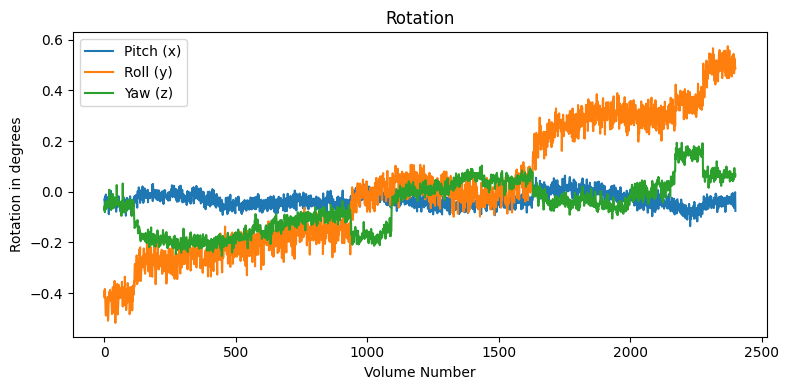

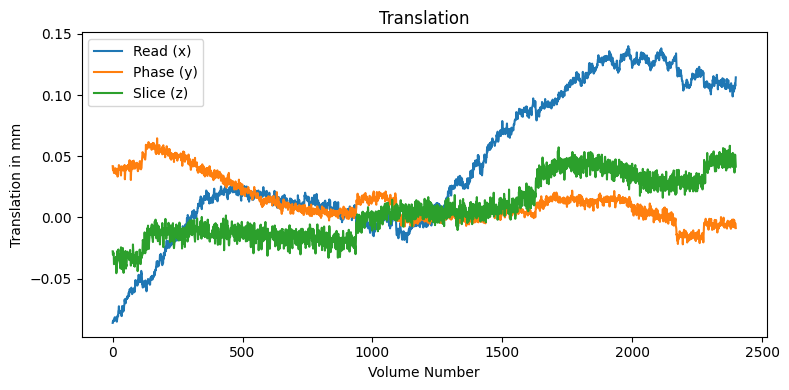

In [28]:
# Applying Motion Correction on raw functional data and plotting motion parameters

print_header("Applying Motion Correction on raw functional data and plotting motion parameters", bcolors.HEADER)

path_raw_func = os.path.join(in_path, func_scan_number)
params = func_param_extract(path_raw_func, export_env=True)
SequenceName = params["SequenceName"]
tr = int(params["VolTR"])
n_vols = params["NoOfRepetitions"]
middle_vol = str(int(n_vols / 2))

print (tr)
extract_middle_volume("G1_cp_resampled.nii.gz", int(middle_vol), "middle_vol.nii.gz", 1)

if os.path.exists("mc_func.nii.gz"):
    print(f"{bcolors.OKGREEN}Motion Corrected functional data exists. Skipping motion correction.{bcolors.ENDC}")
else:
    motion_correction("middle_vol.nii.gz", input_vol="G1_cp_resampled.nii.gz", output_prefix="mc_func")

plot_motion_parameters("motion.1D")

# Creating a mask to be applied on functional data using the mean baseline image

In [29]:

#Creating a mask to be applied on functional data using the mean baseline image
if os.path.exists("mask_mean_mc_func.nii.gz"):
    print(f"{bcolors.OKGREEN}Mask Image exists.{bcolors.ENDC}")
else:
    print(f"{bcolors.FAIL}Mask Image does not exist. Please create the mask and save it as mask_mean_mc_func.nii.gz{bcolors.ENDC}")
    subprocess.run(["fsleyes", "middle_vol.nii.gz"])

if os.path.exists("mask_mean_mc_func_cannulas.nii.gz"):
    print(f"{bcolors.OKGREEN}Mask Image including cannulas exist.{bcolors.ENDC}")
else:
    print(f"{bcolors.FAIL}Mask Image does not exist. Please create the mask that also includes cannulas and save it as mask_mean_mc_func_cannulas.nii.gz.{bcolors.ENDC}")
    shutil.copyfile("mask_mean_mc_func.nii.gz", "mask_mean_mc_func_cannulas.nii.gz")
    subprocess.run(["fsleyes", "mean_image.nii.gz" , "mask_mean_mc_func_cannulas.nii.gz"])
  

Mask Image exists.
Mask Image including cannulas exist.


# Setting up analysis directory

In [30]:
# Setting up analysis directory
print_header("Setting up Analysis Directory", bcolors.HEADER)

folder_created = datetime.datetime.now().strftime('%Y_%m_%d_%H%M%S') + "_" + getpass.getuser()
# path_current_analysis = os.path.join(analysed_path, str(func_scan_number) + SequenceName, datetime.datetime.now().strftime('%Y_%m_%d_%H%M%S') + "_" + getpass.getuser())
path_current_analysis = os.path.join(analysed_path, str(func_scan_number) + SequenceName, folder_created)
os.makedirs(path_current_analysis)
shutil.copy(os.path.join(os.getcwd(), "mc_func.nii.gz"), os.path.join(path_current_analysis))
shutil.copy(os.path.join(os.getcwd(), "mask_mean_mc_func.nii.gz"), os.path.join(path_current_analysis))
os.chdir(path_current_analysis)
cwd = os.getcwd()

print(f"Current Working Directory is: {cwd}")


**************************************************************************************************************************************
                                                    Setting up Analysis Directory                                                     
**************************************************************************************************************************************

Current Working Directory is: /Users/njain/Desktop/Naman/AnalysedData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1/19functionalEPI/2026_01_04_232817_njain


# Setting Up and Extracting all data analysis parameters to be used for Data Analysis

In [31]:
temp_smoothing_window = widgets.IntText(value=10, description="Temporal Smoothing Window:")
# struct_scan_number_entered = widgets.IntText(value=10, description="Structural Scan Number:")
# win_entered = widgets.IntText(value=10, description="Window Duration for Analysing Data:")
display(temp_smoothing_window)



IntText(value=10, description='Temporal Smoothing Window:')

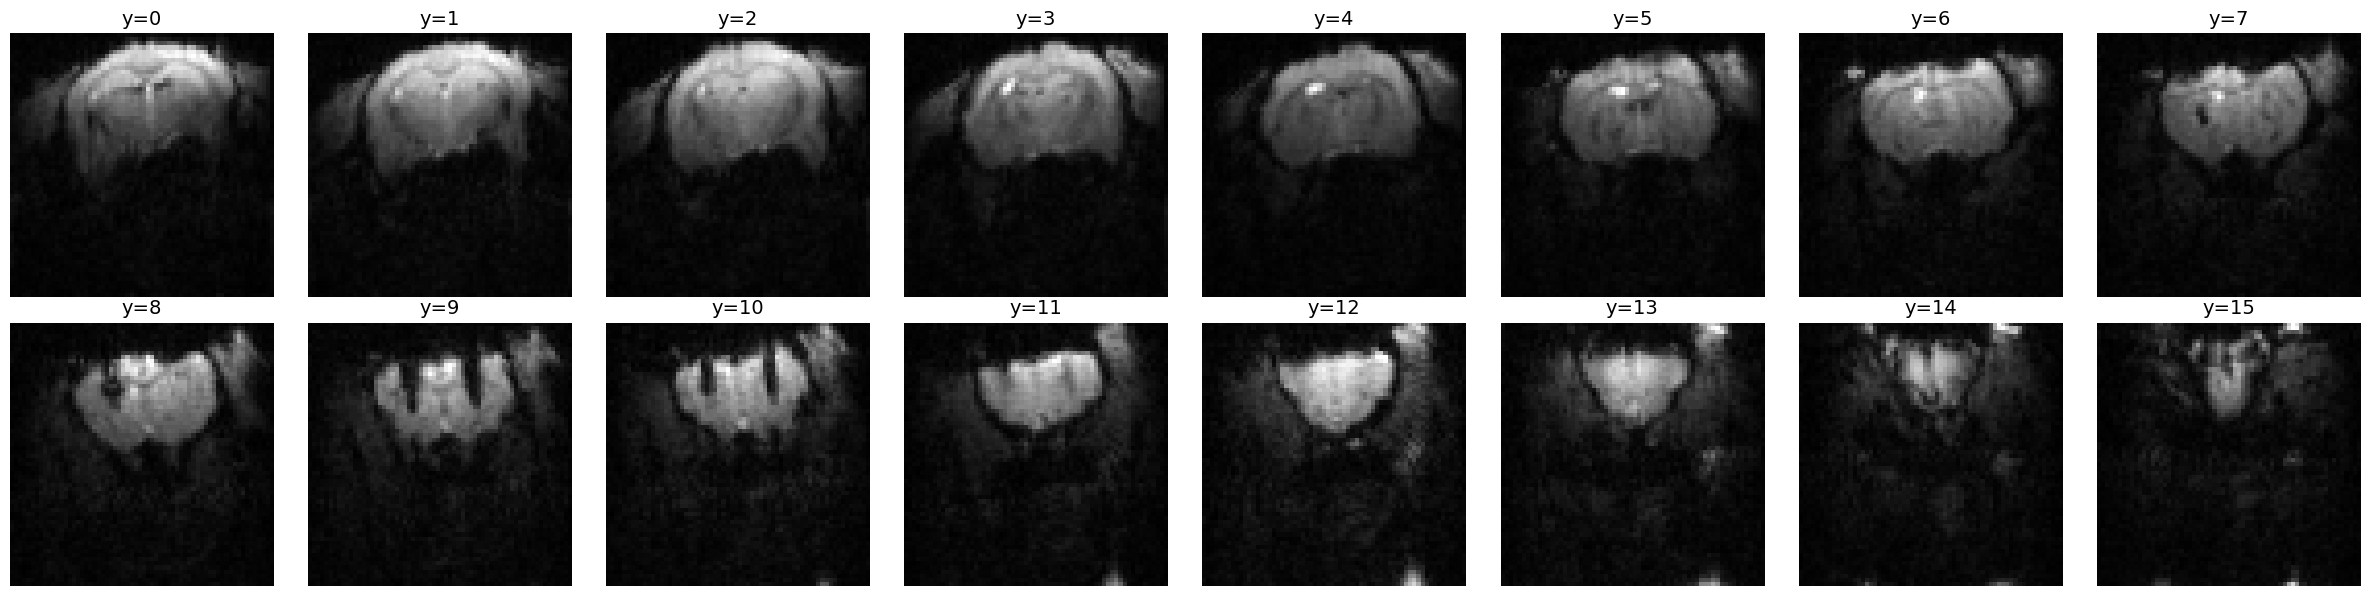

In [33]:
#Display of the motion corrected image
view_images("mc_func.nii.gz", cmap="gray")

# Applying temporal smoothing to the motion corrected functional data to see the temporal signatures

In [34]:
#Applying temporal smoothing to the motion corrected functional data to see the temporal signatures
print_header("Applying temporal smoothing to the motion corrected functional data to see the temporal signatures", bcolors.HEADER)
smooth_movavg("mc_func.nii.gz", "temporal_smoothed_mc_func.nii.gz", temp_smoothing_window.value, tr)



**************************************************************************************************************************************
                  Applying temporal smoothing to the motion corrected functional data to see the temporal signatures                  
**************************************************************************************************************************************

Wrote: temporal_smoothed_mc_func.nii.gz  (TR=1.0s, window=60.0s => 60 vols)


# Choosing signal and baseline volume indices from the temporally smoothed motion corrected functional data

In [35]:
# Opening fsleyes to view the temporally smoothed motion corrected functional data
print_statement("Choose your baseline and signal volumes from the temporally smoothed motion corrected functional data.", bcolors.NOTIFICATION)
subprocess.run(["fsleyes", "temporal_smoothed_mc_func.nii.gz"])

# Choosing signal and baseline volume indices from the temporally smoothed motion corrected functional data
base_start = 400
sig_start  = 1900
# base_start = int(input("Enter baseline start Volume index: "))
# sig_start  = int(input("Enter signal start Volume index: "))
base_end   = base_start + int(win)
sig_end   = sig_start + int(win)

print_statement(f"Your baseline window selected is: {base_start}_to_{base_end}", bcolors.OKGREEN)
print_statement(f"Your signal window selected is: {sig_start}_to_{sig_end}", bcolors.OKGREEN)

compute_mean_range(input_file="temporal_smoothed_mc_func.nii.gz", prefix=f"mean_baseline_image_{base_start}_to_{base_end}.nii.gz", start_idx=base_start, end_idx=base_end)
os.remove(f"mean_baseline_image_{base_start}_to_{base_end}.nii.gz")

Choose your baseline and signal volumes from the temporally smoothed motion corrected functional data.
Your baseline window selected is: 400_to_500
Your signal window selected is: 1900_to_2000
[INFO] Running: 3dTstat -mean -prefix mean_baseline_image_400_to_500.nii.gz temporal_smoothed_mc_func.nii.gz[400..500]


++ 3dTstat: AFNI version=AFNI_24.0.07 (Feb 15 2024) [64-bit]
++ Authored by: KR Hammett & RW Cox


[OK] Mean baseline image saved.


++ Output dataset ./mean_baseline_image_400_to_500.nii.gz


In [36]:
#Masking temporally smoothed motion corrected functional data using the created mask
print_header("Masking temporally smoothed motion corrected functional data using the created mask", bcolors.HEADER)
masking_file(input_file="temporal_smoothed_mc_func.nii.gz", mask_file="mask_mean_mc_func.nii.gz", output_file="cleaned_mc_func.nii.gz") #creating cleaned motion corrected functional data from temporal smoothed data for further processing
masking_file(input_file="mc_func.nii.gz", mask_file="mask_mean_mc_func.nii.gz", output_file="raw_cleaned_mc_func.nii.gz") #creating cleaned motion corrected functional data from raw data for different processing


**************************************************************************************************************************************
                         Masking temporally smoothed motion corrected functional data using the created mask                          
**************************************************************************************************************************************

[OK] Masked file saved → cleaned_mc_func.nii.gz
[OK] Masked file saved → raw_cleaned_mc_func.nii.gz


'raw_cleaned_mc_func.nii.gz'

# Estimating tSNR using the cleaned motion corrected functional data


**************************************************************************************************************************************
                                  Estimating tSNR using the cleaned motion corrected functional data                                  
**************************************************************************************************************************************

[OK] Intended Volumes extracted.
[OK] tSNR file saved → tSNR_mc_func.nii.gz


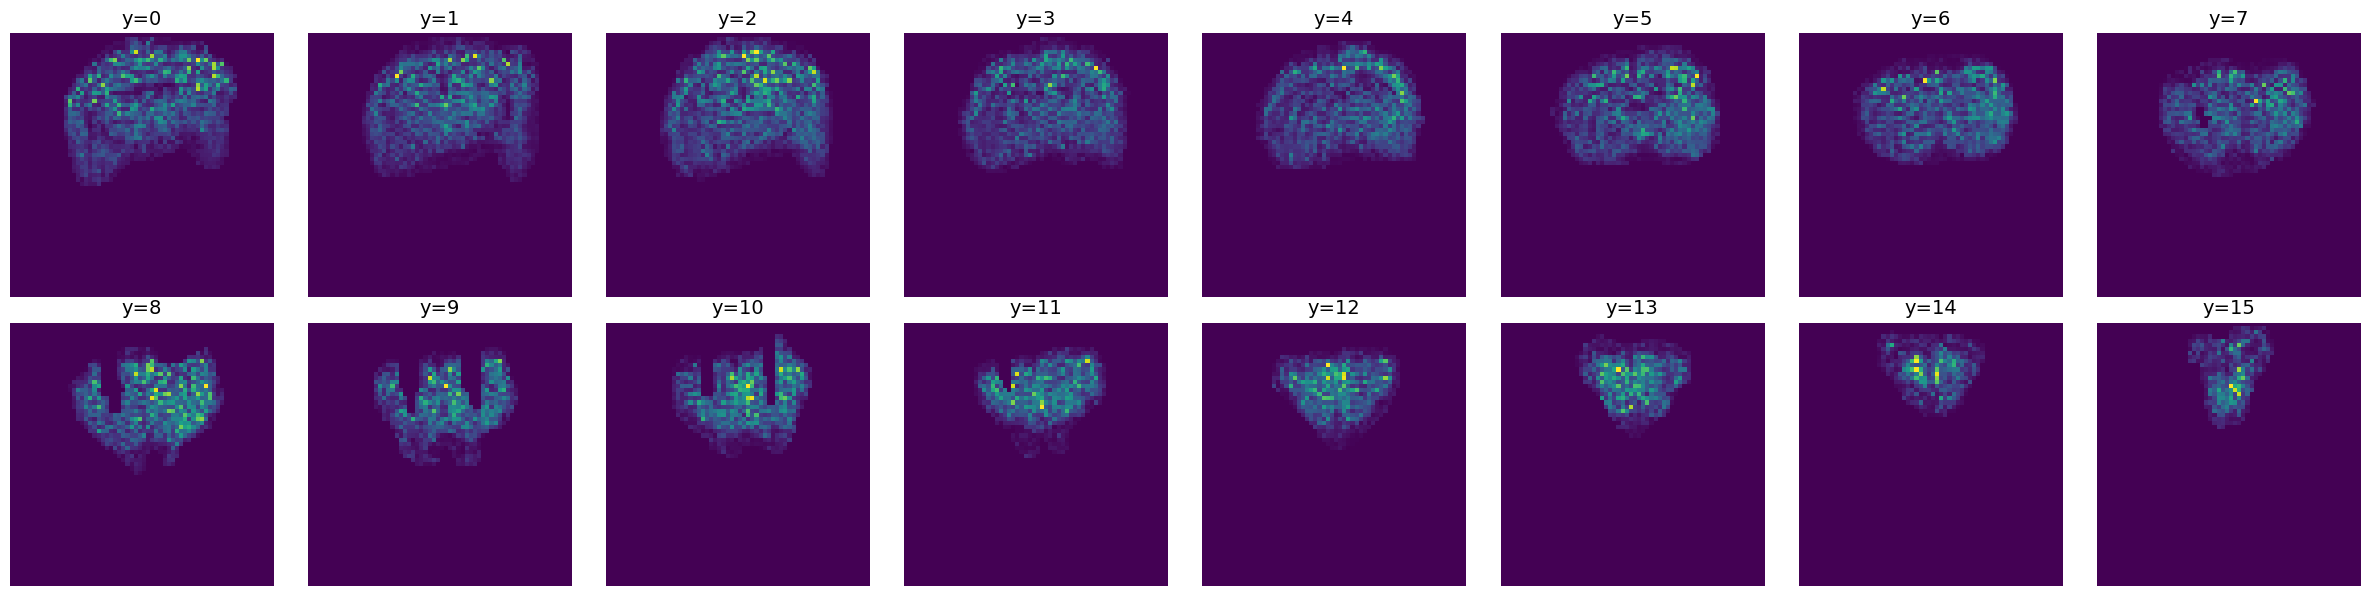

In [37]:
#Estimating tSNR using the cleaned motion corrected functional data
print_header("Estimating tSNR using the cleaned motion corrected functional data", bcolors.HEADER)
tSNR(input_file="cleaned_mc_func.nii.gz", reference_vol=100, output_file="tSNR_mc_func.nii.gz", size=400)
view_images("tSNR_mc_func.nii.gz", cmap="viridis")

# Applying isotropic spatial smoothing on cleaned motion corrected functional data


**************************************************************************************************************************************
                                    Applying isotropic spatial smoothing on cleaned_mc_func.nii.gz                                    
**************************************************************************************************************************************

[OK] Spatially smoothed file saved → smoothed_cleaned_mc_func.nii.gz


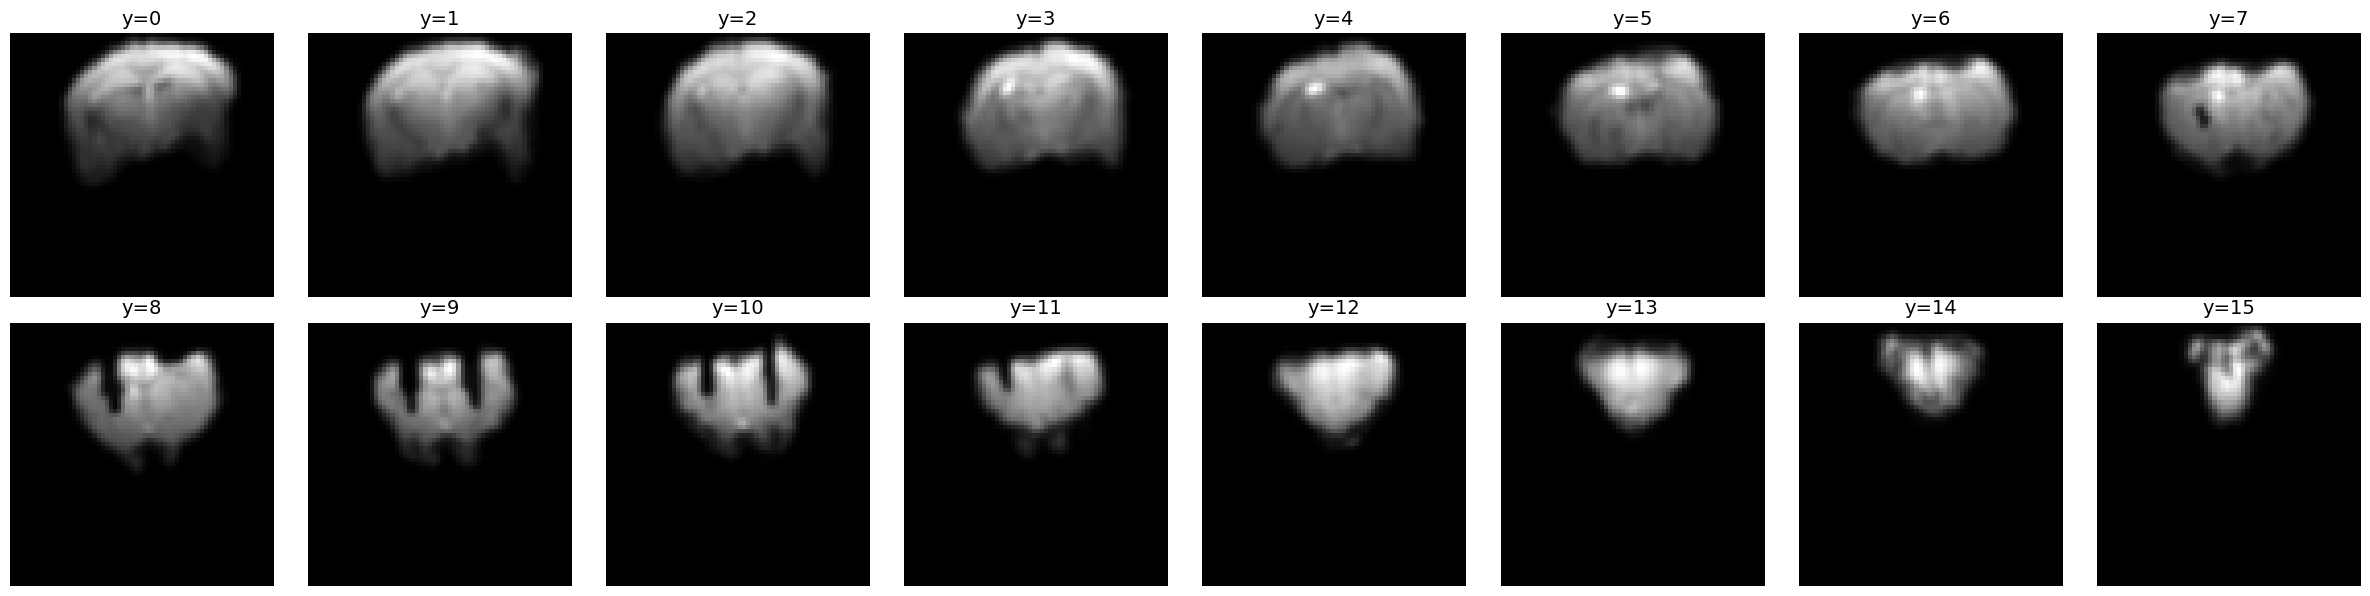

In [38]:
# Applying isotropic spatial smoothing on cleaned motion corrected functional data
fwhm_kernel = float(0.7)
print_header("Applying isotropic spatial smoothing on cleaned_mc_func.nii.gz", bcolors.HEADER)
spatial_smoothing('cleaned_mc_func.nii.gz', 'smoothed_cleaned_mc_func.nii.gz', fwhm_kernel)
view_images("smoothed_cleaned_mc_func.nii.gz", cmap="gray")

# Generating Signal Change Map and Signal Change Time Series


**************************************************************************************************************************************
                                      Generating Signal Change Map and Signal Change Time Series                                      
**************************************************************************************************************************************

[INFO] Running: 3dTstat -mean -prefix mean_baseline_image_400_to_500.nii.gz smoothed_cleaned_mc_func.nii.gz[400..500]


++ 3dTstat: AFNI version=AFNI_24.0.07 (Feb 15 2024) [64-bit]
++ Authored by: KR Hammett & RW Cox
++ Output dataset ./mean_baseline_image_400_to_500.nii.gz
++ 3dTstat: AFNI version=AFNI_24.0.07 (Feb 15 2024) [64-bit]
++ Authored by: KR Hammett & RW Cox


[OK] Mean baseline image saved.
[INFO] Running: 3dTstat -mean -prefix mean_signal_image_1900_to_2000.nii.gz smoothed_cleaned_mc_func.nii.gz[1900..2000]


++ Output dataset ./mean_signal_image_1900_to_2000.nii.gz


[OK] Mean baseline image saved.
[OK] Percent Signal Change Map saved → tmp_signal_change_map.nii.gz
[OK] Masked file saved → cleaned_SCM_func.nii.gz


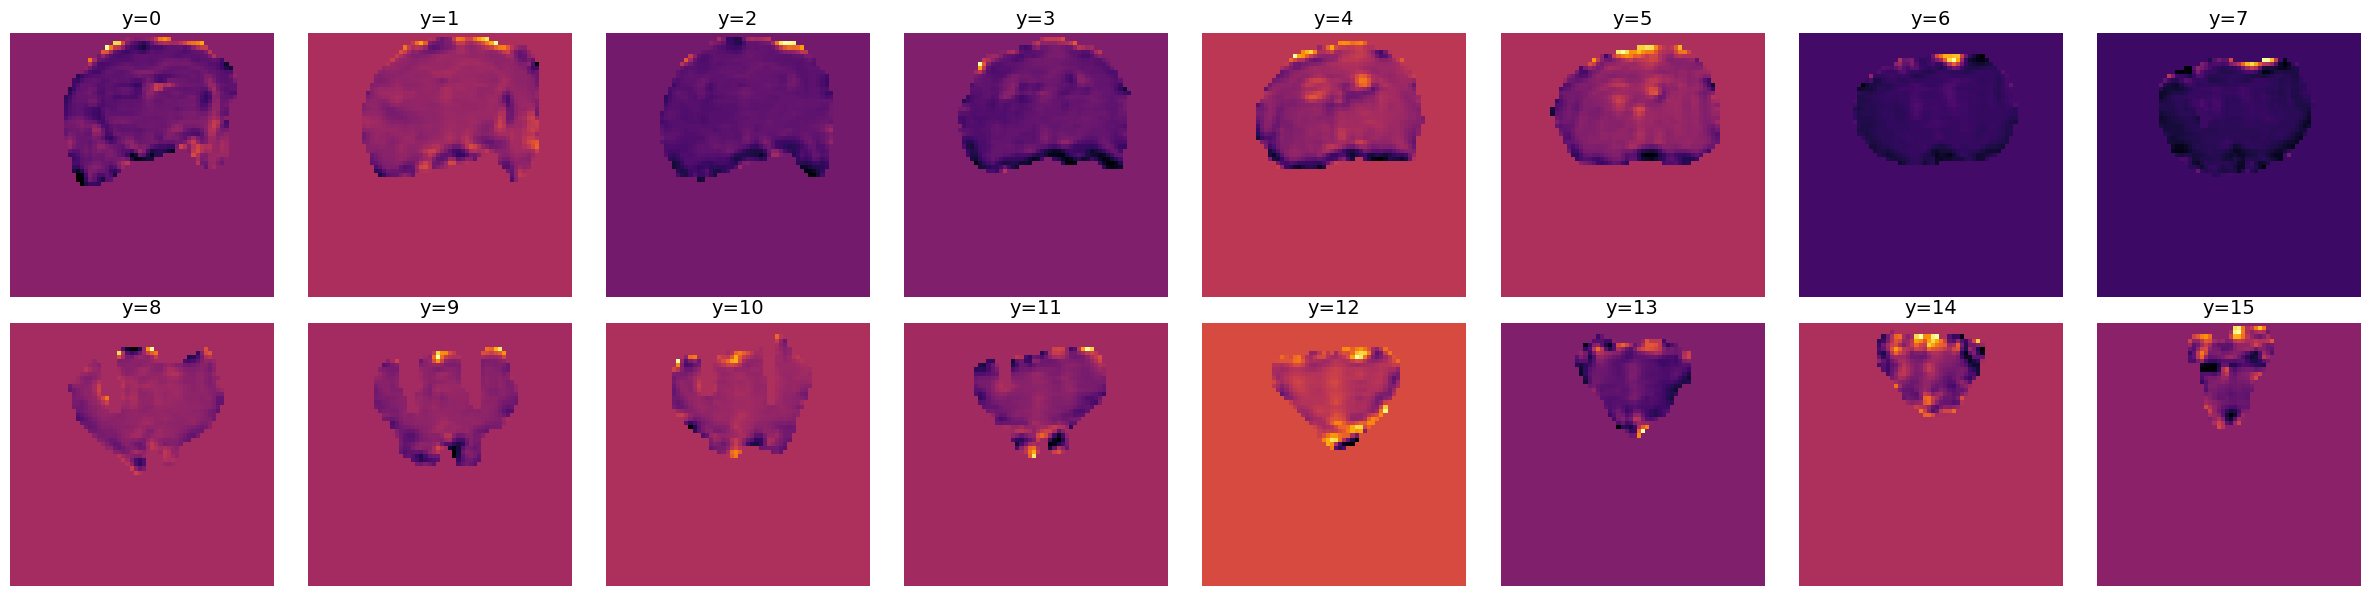

In [39]:
#Generating Signal Change Map

print_header("Generating Signal Change Map and Signal Change Time Series", bcolors.HEADER)

compute_mean_range(input_file="smoothed_cleaned_mc_func.nii.gz", prefix=f"mean_baseline_image_{base_start}_to_{base_end}.nii.gz", start_idx=base_start, end_idx=base_end)
compute_mean_range(input_file="smoothed_cleaned_mc_func.nii.gz", prefix=f"mean_signal_image_{sig_start}_to_{sig_end}.nii.gz", start_idx=sig_start, end_idx=sig_end)

signal_change_map(f"mean_signal_image_{sig_start}_to_{sig_end}.nii.gz", f"mean_baseline_image_{base_start}_to_{base_end}.nii.gz", "tmp_signal_change_map.nii.gz")
masking_file(input_file="tmp_signal_change_map.nii.gz", mask_file="mask_mean_mc_func.nii.gz", output_file="cleaned_SCM_func.nii.gz") #cleaning the signal change map
os.remove("tmp_signal_change_map.nii.gz")
view_images("cleaned_SCM_func.nii.gz", cmap="inferno")


In [40]:
# Creating time series of signal change

print_header("Creating time series of signal change", bcolors.HEADER)

compute_mean_range(input_file="smoothed_cleaned_mc_func.nii.gz", prefix=f"mean_sm_baseline_image_{base_start}_to_{base_end}.nii.gz", start_idx=base_start, end_idx=base_end)
signal_change_map("smoothed_cleaned_mc_func.nii.gz", f"mean_sm_baseline_image_{base_start}_to_{base_end}.nii.gz", "tmp_signal_change_time_series.nii.gz")
masking_file("tmp_signal_change_time_series.nii.gz", "mask_mean_mc_func.nii.gz", "norm_cleaned_mc_func.nii.gz")
os.remove("tmp_signal_change_time_series.nii.gz")



**************************************************************************************************************************************
                                                Creating time series of signal change                                                 
**************************************************************************************************************************************

[INFO] Running: 3dTstat -mean -prefix mean_sm_baseline_image_400_to_500.nii.gz smoothed_cleaned_mc_func.nii.gz[400..500]


++ 3dTstat: AFNI version=AFNI_24.0.07 (Feb 15 2024) [64-bit]
++ Authored by: KR Hammett & RW Cox
++ Output dataset ./mean_sm_baseline_image_400_to_500.nii.gz


[OK] Mean baseline image saved.
[OK] Percent Signal Change Map saved → tmp_signal_change_time_series.nii.gz
[OK] Masked file saved → norm_cleaned_mc_func.nii.gz


# Cleaning the structural image by masking it with a manually created mask


**************************************************************************************************************************************
                                       Cleaning the structural image by manually creating mask                                        
**************************************************************************************************************************************

Structural Image for Coregistration exists.


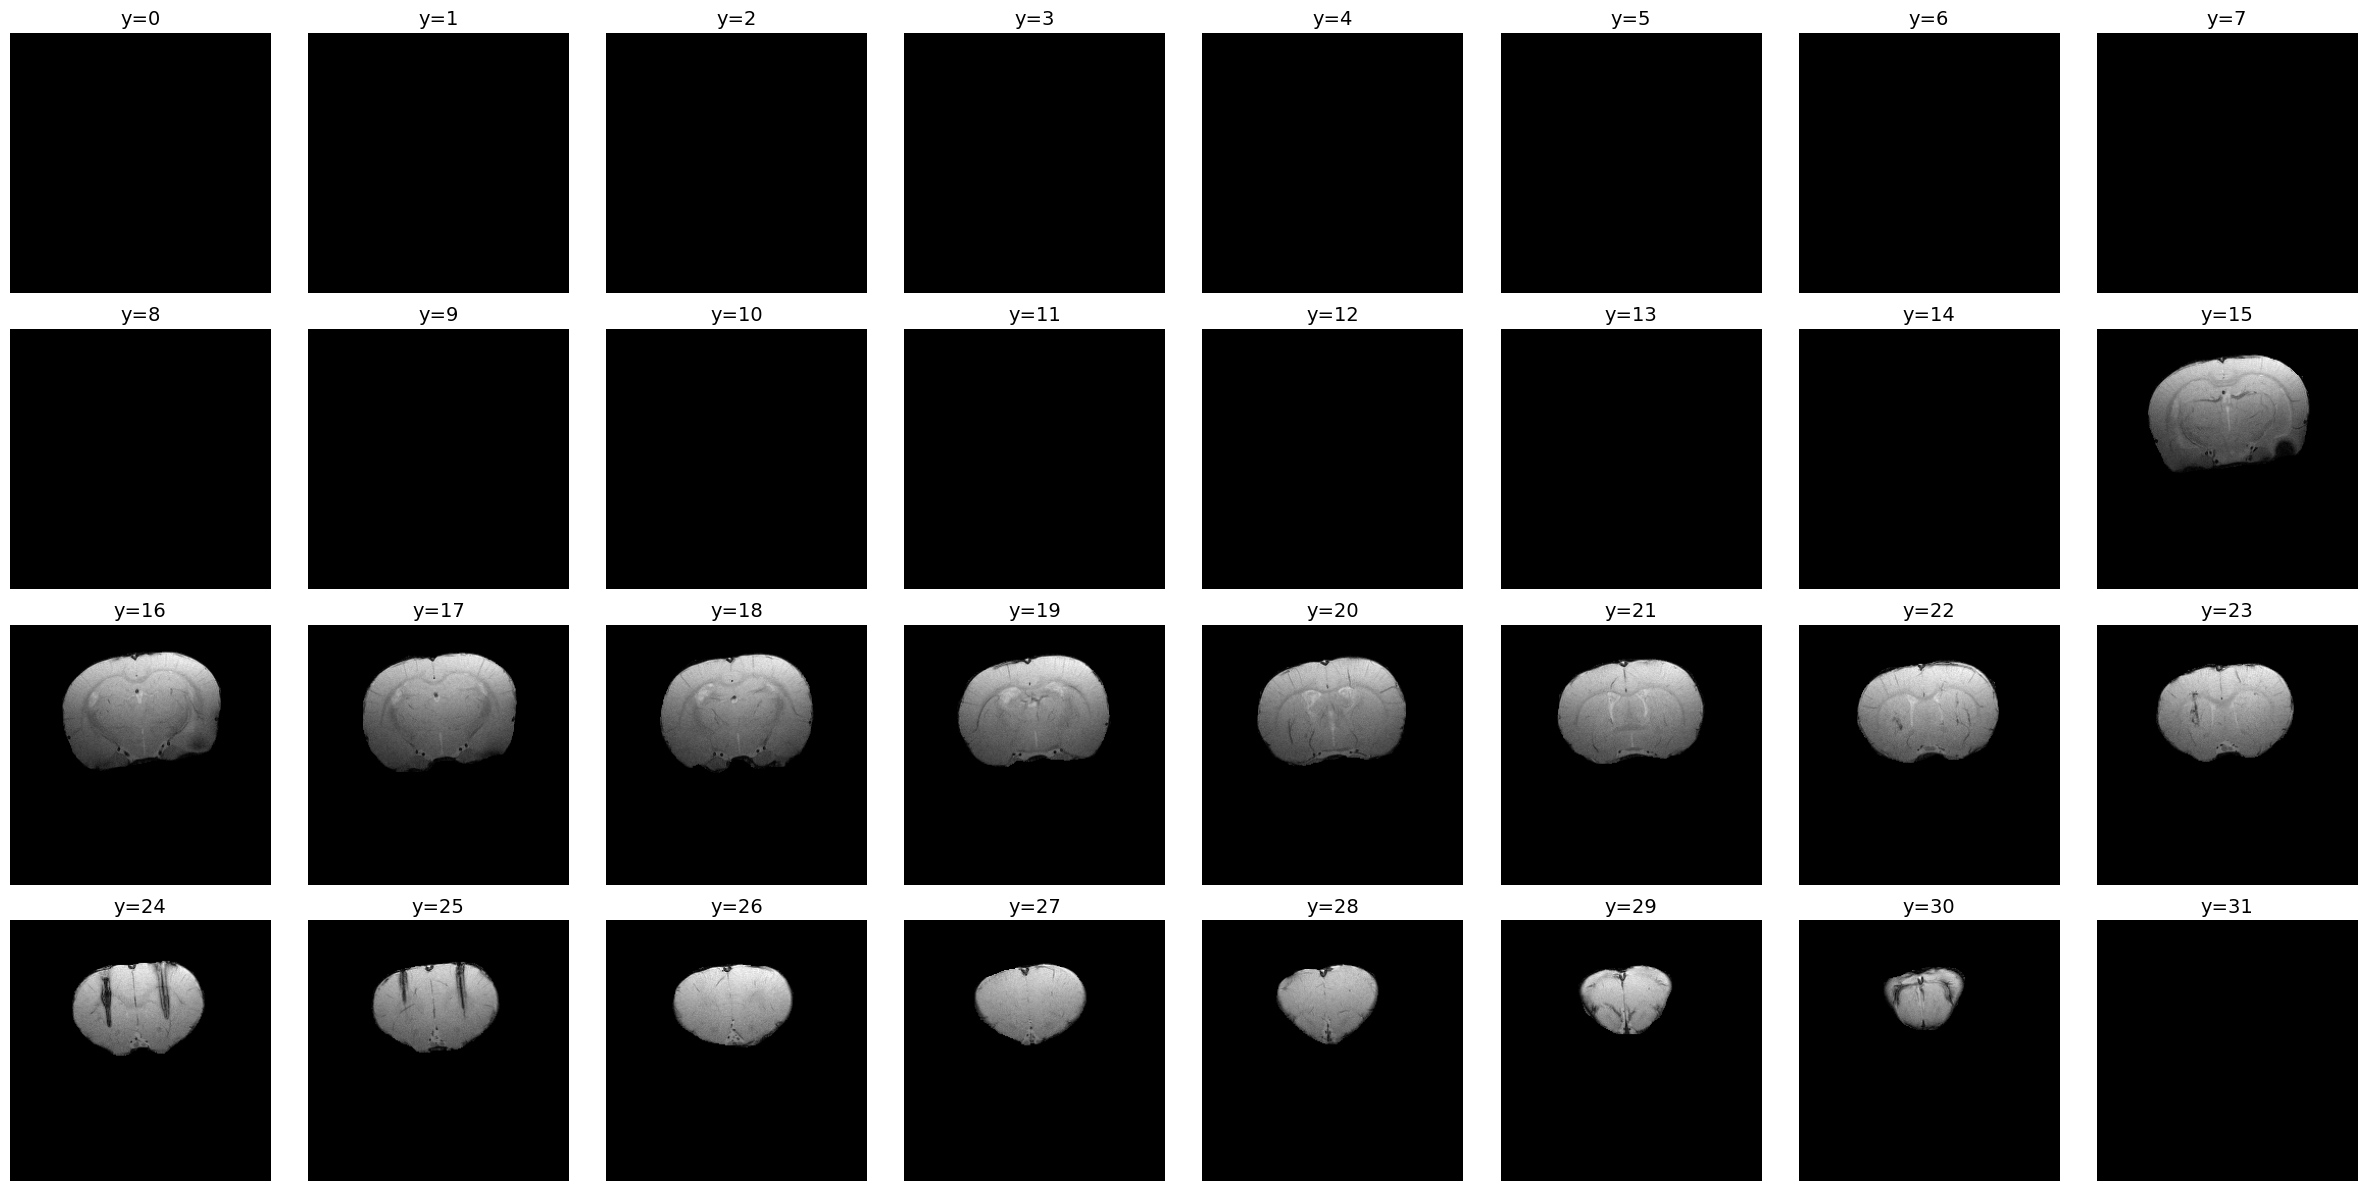

[OK] Masked file saved → cleaned_mean_mc_func_cannulas.nii.gz
[OK] Masked file saved → cleaned_mc_func_cannulas.nii.gz


'cleaned_mc_func_cannulas.nii.gz'

In [41]:
#Cleaning the structural image by masking it with a manually created mask

print_header("Cleaning the structural image by manually creating mask", bcolors.HEADER)
params_struct = func_param_extract(os.path.join(in_path, struct_scan_number), export_env=True)
seq_name_struct = params_struct["SequenceName"]
struct_coreg_dir = os.path.join(analysed_path, str(struct_scan_number) + seq_name_struct)

structural_file_for_coregistration = os.path.join(struct_coreg_dir, "cleaned_anatomy.nii.gz")
if os.path.exists(os.path.join(struct_coreg_dir, "cleaned_anatomy.nii.gz")):
    print_statement("Structural Image for Coregistration exists.", bcolors.OKGREEN)
else:
    print_statement("Please create a mask for the structural image and save it as mask_anatomy.nii.gz", bcolors.NOTIFICATION)
    subprocess.run(["fsleyes", os.path.join(struct_coreg_dir, "G1_cp_resampled.nii.gz")])
    masking_file(os.path.join(struct_coreg_dir, "G1_cp_resampled.nii.gz"), os.path.join(struct_coreg_dir, "mask_anatomy.nii.gz"), structural_file_for_coregistration)

view_images(os.path.join(struct_coreg_dir, "cleaned_anatomy.nii.gz"), cmap="gray")

masking_file(os.path.join(analysed_path, str(func_scan_number) + SequenceName, "middle_vol.nii.gz"), os.path.join(analysed_path, str(func_scan_number) + SequenceName, "mask_mean_mc_func_cannulas.nii.gz"), "cleaned_mean_mc_func_cannulas.nii.gz")
masking_file(os.path.join(analysed_path, str(func_scan_number) + SequenceName, "mc_func.nii.gz"), os.path.join(analysed_path, str(func_scan_number) + SequenceName, "mask_mean_mc_func_cannulas.nii.gz"), "cleaned_mc_func_cannulas.nii.gz")


# Coregistering functional time series and functional signal change map to structural image

In [42]:
#Coregistering functional time series and functional signal change map to structural image
print_header("Coregistering functional time series and functional signal change map to structural image", bcolors.HEADER)
affine_matrix_file = ("mean_func_struct_aligned.aff12.1D")
if os.path.exists(affine_matrix_file):
   print_statement("Affine Matrix to coregister Signal Change Map exists.", bcolors.OKGREEN)
else:
   print_statement("Estimating Affine Matrix to coregister Signal Change Map.", bcolors.NOTIFICATION)
   coregistration_afni(input_file1="cleaned_mean_mc_func_cannulas.nii.gz", input_file2="cleaned_SCM_func.nii.gz", reference_file= structural_file_for_coregistration, output_file1="mean_func_struct_aligned.nii.gz", output_file2="signal_change_map_coregistered_structural_space.nii.gz", estimate_affine=True, apply_affine=True, affine_mat="mean_func_struct_aligned.aff12.1D")



**************************************************************************************************************************************
                      Coregistering functional time series and functional signal change map to structural image                       
**************************************************************************************************************************************

Estimating Affine Matrix to coregister Signal Change Map.
260104-23:40:02,894 nipype.interface INFO:
	 stderr 2026-01-04T23:40:02.894584:++ 3dAllineate: AFNI version=AFNI_24.0.07 (Feb 15 2024) [64-bit]
260104-23:40:02,895 nipype.interface INFO:
	 stderr 2026-01-04T23:40:02.894584:++ Authored by: Zhark the Registrator
260104-23:40:02,898 nipype.interface INFO:
	 stderr 2026-01-04T23:40:02.898236:++ Source dataset: /Users/njain/Desktop/Naman/AnalysedData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1/19functionalEPI/2026_01_04_232817_njain/cleaned_mean_mc_func_cannulas.nii.gz
260104-

# Coregistering functional time series and generating signal change map from coregistered data

In [43]:
#Coregistering functional time series and generating signal change map from coregistered data

print_header("Coregistering functional time series and generating signal change map from coregistered data", bcolors.HEADER)
coregistration_afni(input_file1=None, input_file2="cleaned_mc_func_cannulas.nii.gz", reference_file= structural_file_for_coregistration, output_file1=None, output_file2="fMRI_coregistered_to_struct.nii.gz", estimate_affine=False, apply_affine=True, affine_mat="mean_func_struct_aligned.aff12.1D")

mean = fsl.maths.MeanImage()
mean.inputs.in_file = "fMRI_coregistered_to_struct.nii.gz"
mean.inputs.out_file = "mean_fMRI_coregistered_to_struct.nii.gz"
mean.run()



**************************************************************************************************************************************
                     Coregistering functional time series and generating signal change map from coregistered data                     
**************************************************************************************************************************************

260104-23:41:03,886 nipype.interface INFO:
	 stderr 2026-01-04T23:41:03.886687:++ 3dAllineate: AFNI version=AFNI_24.0.07 (Feb 15 2024) [64-bit]
260104-23:41:03,887 nipype.interface INFO:
	 stderr 2026-01-04T23:41:03.886687:++ Authored by: Zhark the Registrator
260104-23:41:03,893 nipype.interface INFO:
	 stderr 2026-01-04T23:41:03.893316:++ Source dataset: /Users/njain/Desktop/Naman/AnalysedData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1/19functionalEPI/2026_01_04_232817_njain/cleaned_mc_func_cannulas.nii.gz
260104-23:41:03,893 nipype.interface INFO:
	 stderr 2026-01-04T23:41:0

# Spatially smoothing of the coregistered image

[OK] Spatially smoothed file saved → sm_fMRI_coregistered_to_struct.nii.gz


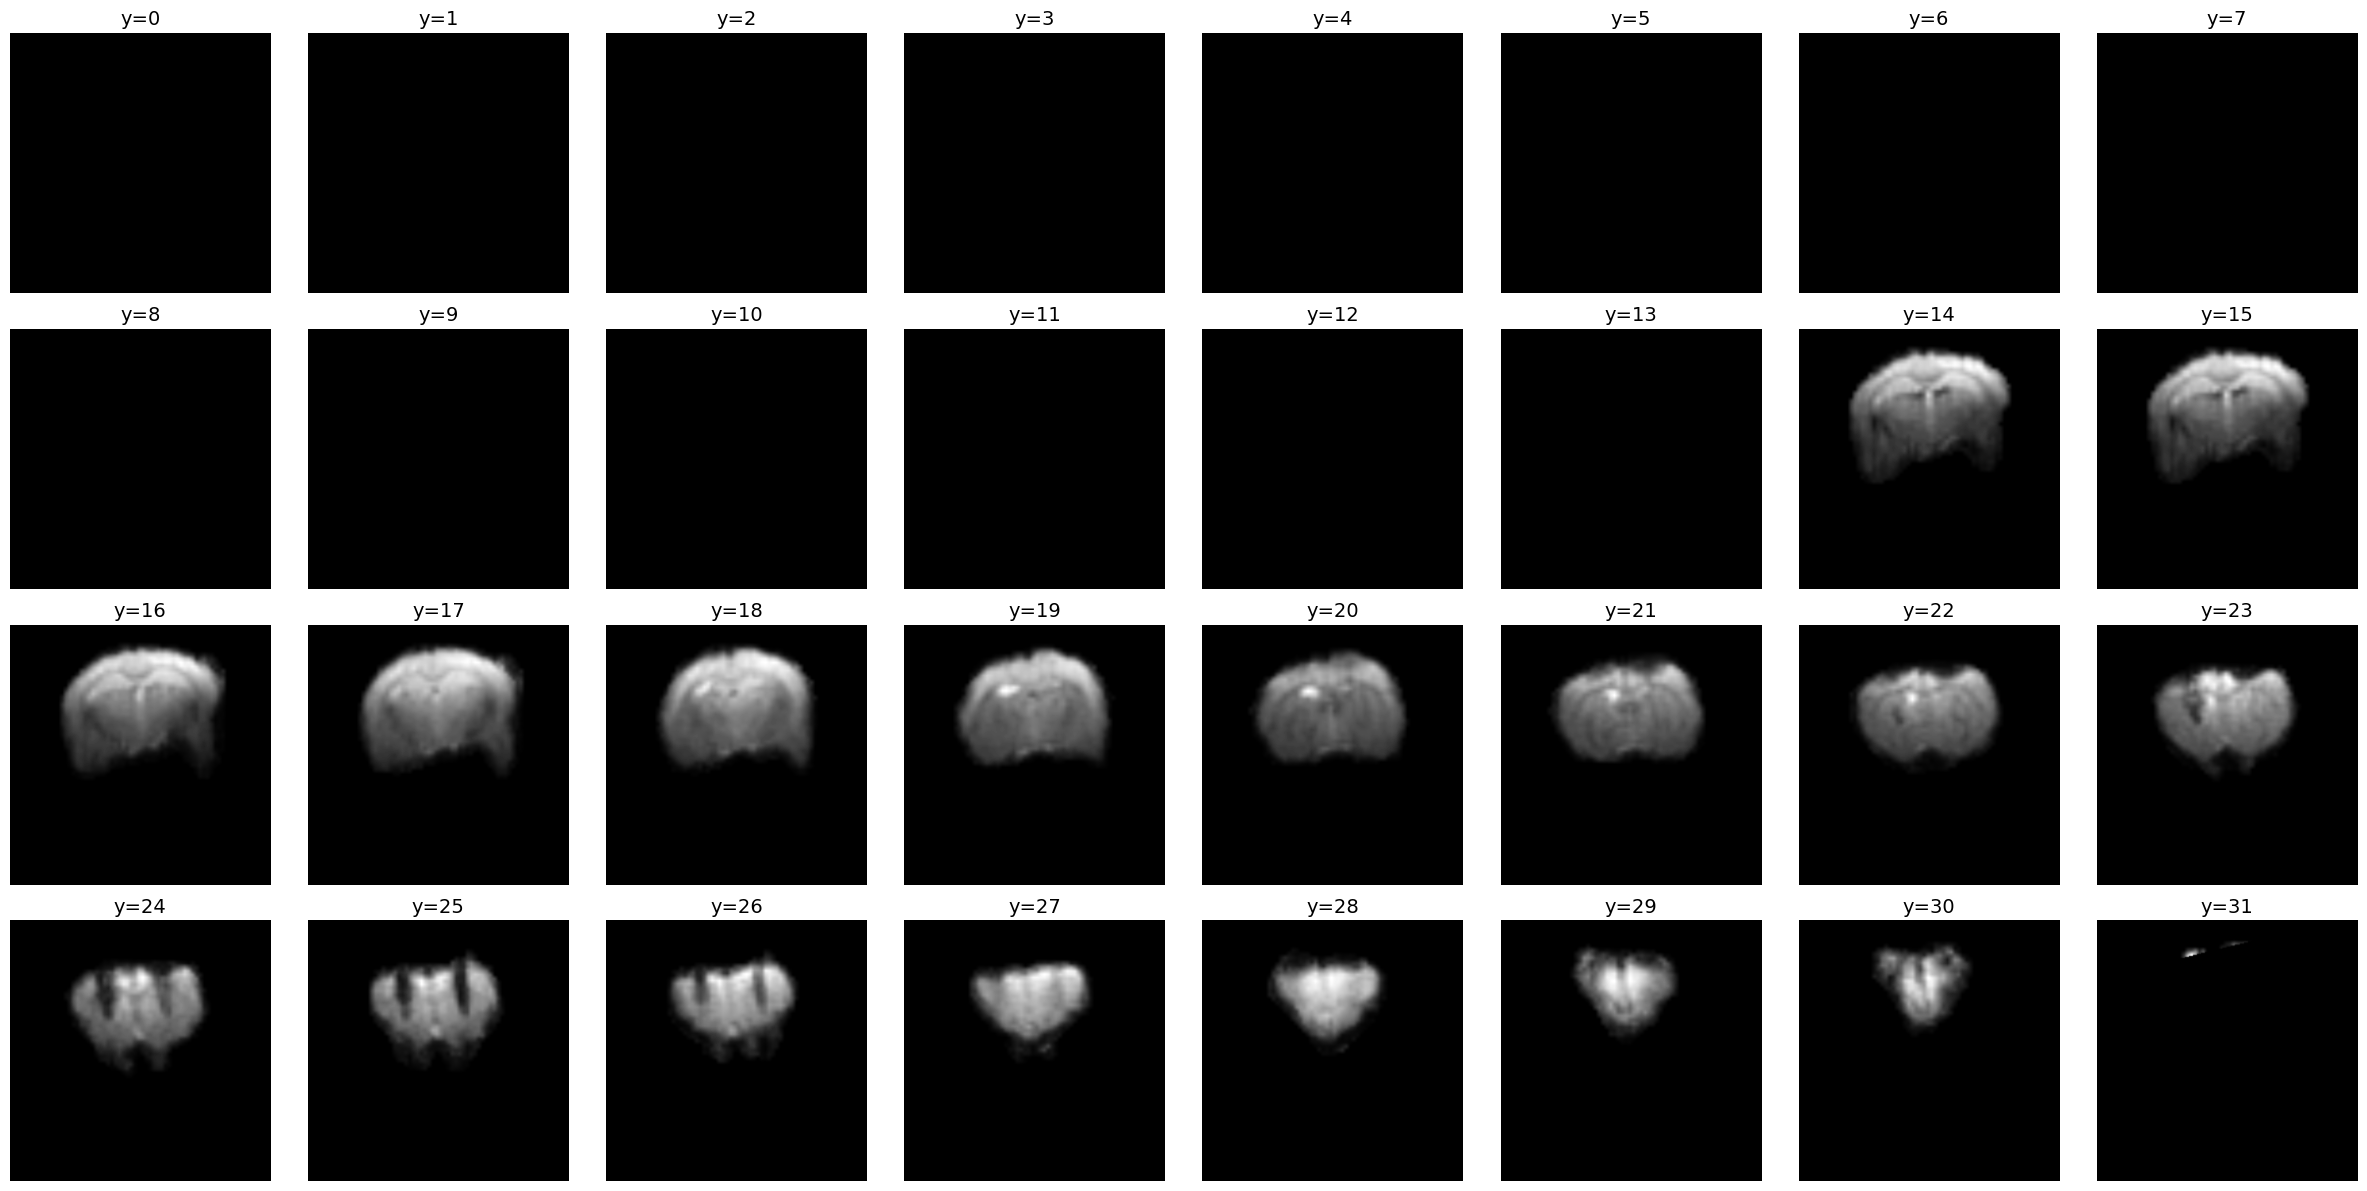

In [44]:
#Spatially smoothing of the coregistered image
fwhm_kernel_coregsitered = float(0.12)
spatial_smoothing("fMRI_coregistered_to_struct.nii.gz", "sm_fMRI_coregistered_to_struct.nii.gz", fwhm_kernel_coregsitered)
view_images("sm_fMRI_coregistered_to_struct.nii.gz", cmap="gray")

Mask file mask_mean_fMRI_coregistered_to_struct.nii.gz exists.
[OK] Masked file saved → sm_fMRI_for_scm.nii.gz
[INFO] Running: 3dTstat -mean -prefix baseline_sm_fMRI_for_scm_400_to_500.nii.gz sm_fMRI_for_scm.nii.gz[400..500]


++ 3dTstat: AFNI version=AFNI_24.0.07 (Feb 15 2024) [64-bit]
++ Authored by: KR Hammett & RW Cox
++ Output dataset ./baseline_sm_fMRI_for_scm_400_to_500.nii.gz
++ 3dTstat: AFNI version=AFNI_24.0.07 (Feb 15 2024) [64-bit]
++ Authored by: KR Hammett & RW Cox


[OK] Mean baseline image saved.
[INFO] Running: 3dTstat -mean -prefix signal_sm_fMRI_for_scm_1900_to_2000.nii.gz sm_fMRI_for_scm.nii.gz[1900..2000]


++ Output dataset ./signal_sm_fMRI_for_scm_1900_to_2000.nii.gz


[OK] Mean baseline image saved.
[OK] Percent Signal Change Map saved → sm_coreg_func_Static_Map_400_to_500_and_1900_to_2000.nii.gz
[OK] Masked file saved → cleaned_sm_scm_from_coregistered_ts.nii.gz


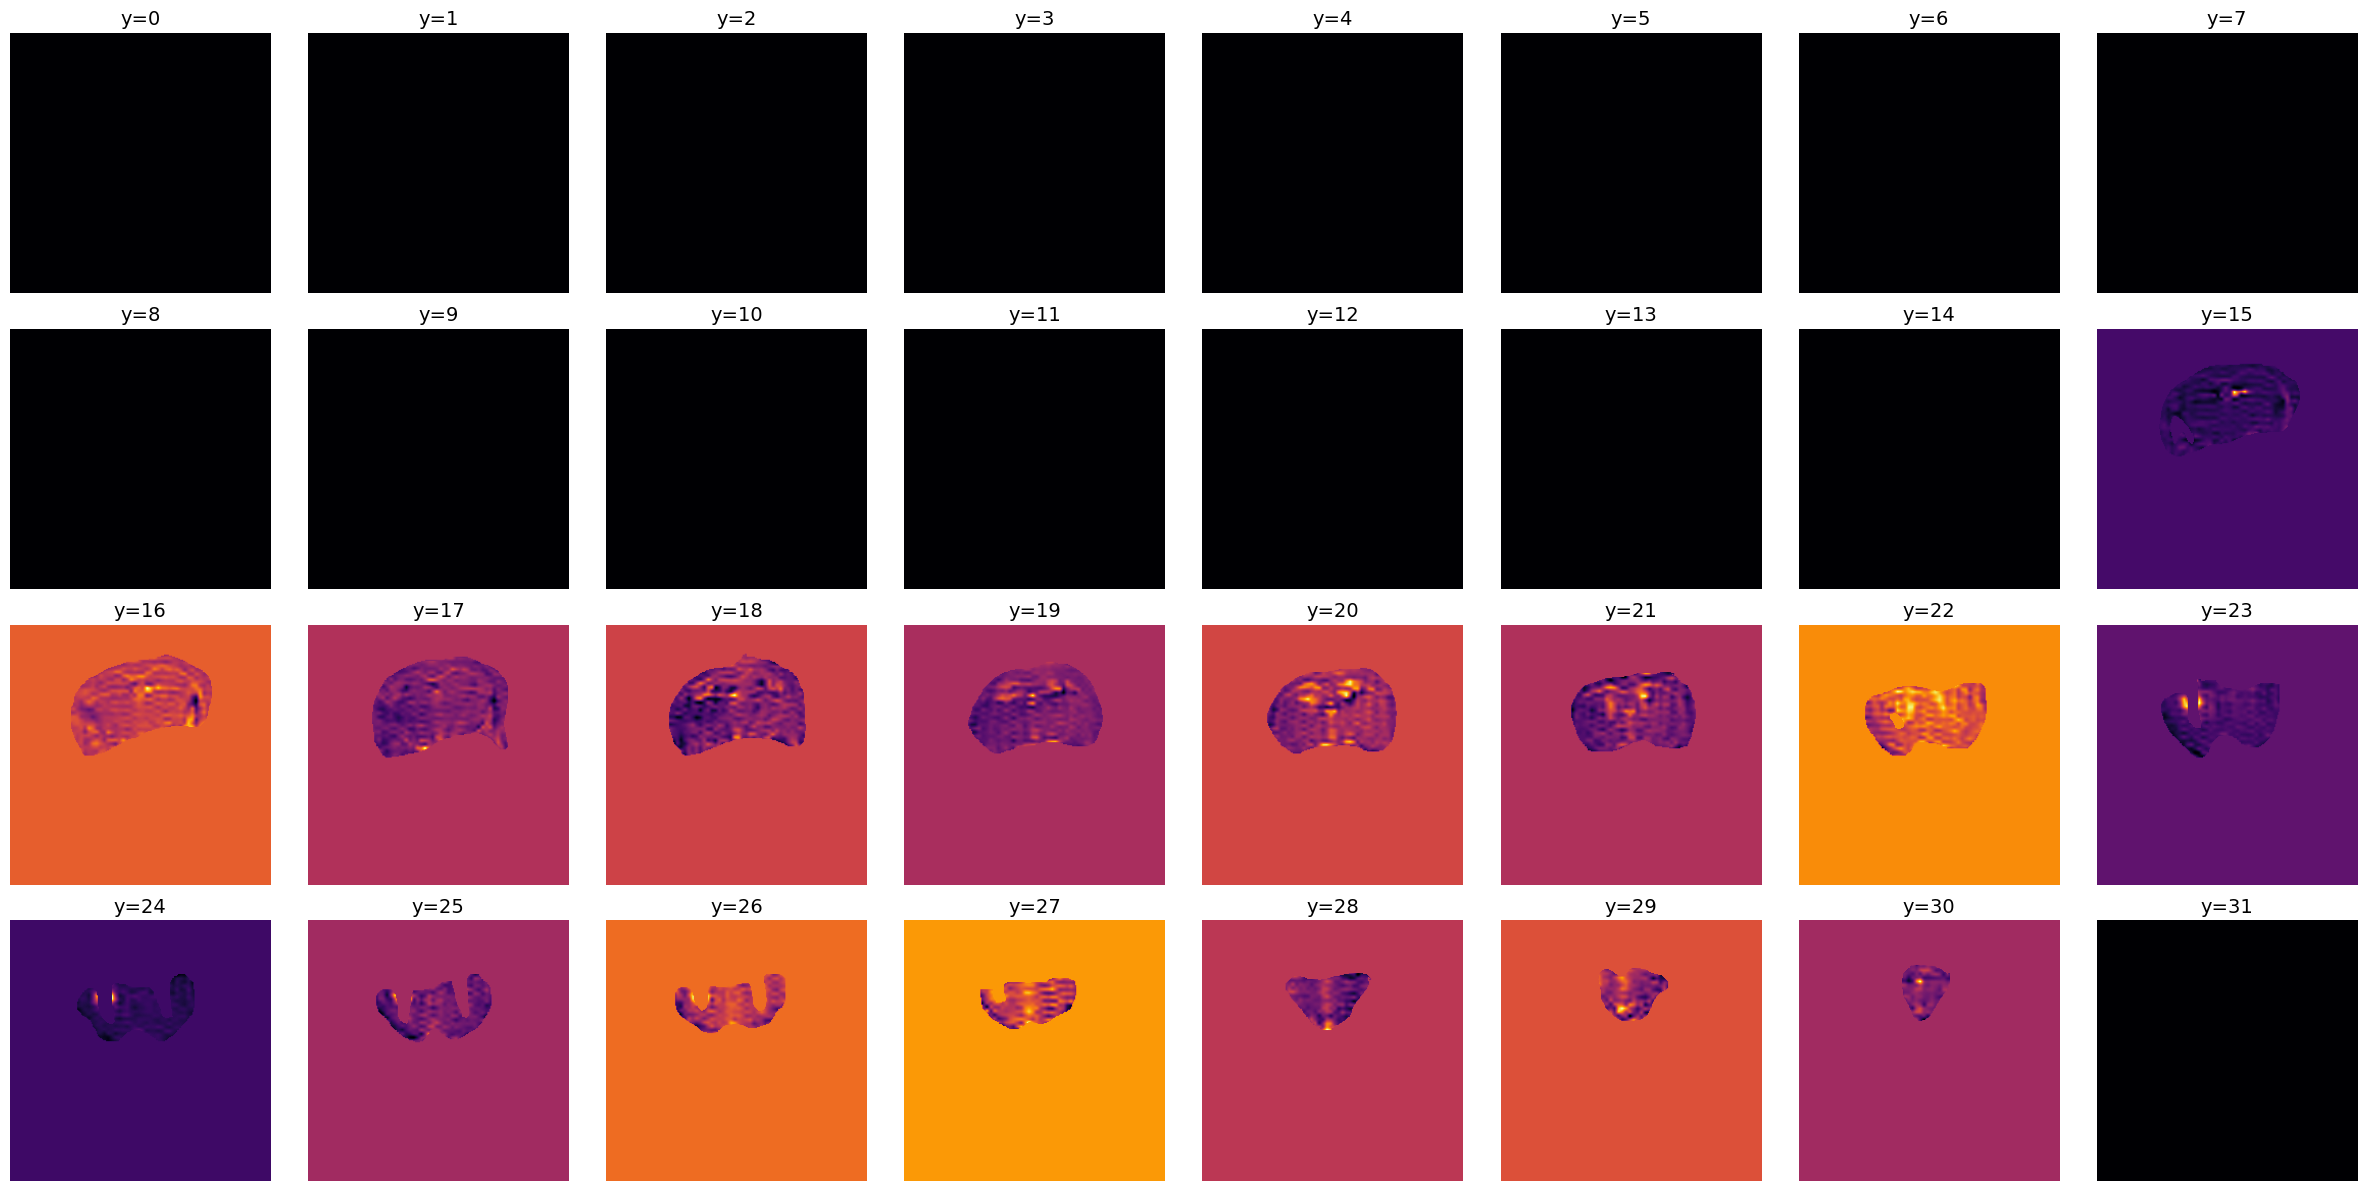

In [45]:


if os.path.exists(os.path.join(analysed_path, str(func_scan_number) + SequenceName, "mask_mean_fMRI_coregistered_to_struct.nii.gz")):
    print("Mask file mask_mean_fMRI_coregistered_to_struct.nii.gz exists.")
else:
    print("Please create a mask and save it as mask_mean_fMRI_coregistered_to_struct.nii.gz")
    subprocess.run(["fsleyes", "mean_fMRI_coregistered_to_struct.nii.gz"])
    shutil.copyfile(os.path.join(analysed_path, str(func_scan_number) + SequenceName, "mask_mean_fMRI_coregistered_to_struct.nii.gz"), "mask_mean_fMRI_coregistered_to_struct.nii.gz")

masking_file("sm_fMRI_coregistered_to_struct.nii.gz", os.path.join(analysed_path, str(func_scan_number) + SequenceName, "mask_mean_fMRI_coregistered_to_struct.nii.gz"), "sm_fMRI_for_scm.nii.gz")

compute_mean_range(input_file="sm_fMRI_for_scm.nii.gz", prefix=f"baseline_sm_fMRI_for_scm_{base_start}_to_{base_end}.nii.gz", start_idx=base_start, end_idx=base_end)
compute_mean_range(input_file="sm_fMRI_for_scm.nii.gz", prefix=f"signal_sm_fMRI_for_scm_{sig_start}_to_{sig_end}.nii.gz", start_idx=sig_start, end_idx=sig_end)

signal_change_map(f"signal_sm_fMRI_for_scm_{sig_start}_to_{sig_end}.nii.gz", f"baseline_sm_fMRI_for_scm_{base_start}_to_{base_end}.nii.gz", f"sm_coreg_func_Static_Map_{base_start}_to_{base_end}_and_{sig_start}_to_{sig_end}.nii.gz")
masking_file(f"sm_coreg_func_Static_Map_{base_start}_to_{base_end}_and_{sig_start}_to_{sig_end}.nii.gz", os.path.join(analysed_path, str(func_scan_number) + SequenceName, "mask_mean_fMRI_coregistered_to_struct.nii.gz"), "cleaned_sm_scm_from_coregistered_ts.nii.gz")

view_images("cleaned_sm_scm_from_coregistered_ts.nii.gz", cmap="inferno")

# Marking ROIs and saving time courses

In [46]:
files_list_roi = os.listdir(cwd)
roi_for_psc = [file for file in files_list_roi if file.startswith("roi_") and file.endswith(".nii.gz")]
roi_left = str([file for file in files_list_roi if file.startswith("roi_") and file.endswith("left.nii.gz")])
roi_right = str([file for file in files_list_roi if file.startswith("roi_") and file.endswith("right.nii.gz")])

roi_left_name = ""
roi_right_name = ""

if os.path.exists(roi_left) and os.path.exists(roi_right):
  roi_left_name = roi_left
  roi_right_name = roi_right

elif os.path.exists(roi_left):
    roi_left_name = roi_left

elif os.path.exists(roi_right):
    roi_right_name = roi_right

print(roi_left_name)
print(roi_right_name)


**************************************************************************************************************************************
                                                 Marking ROIs and saving time courses                                                 
**************************************************************************************************************************************

Please create ROIs on the functional time series and save them in the following particular format:
roi_{what protein/aav is there}_{is it direct injection or aav}_{analyte injeted}_{hemisphere side}.nii.gz
For Example: if GCaMP6f is directly injected in the left hemisphere and dopamine is injected in the right hemisphere following a viral injection, then the following ROIs should be created:
roi_GCaMP6f_direct_left.nii.gz or roi_dopamine_aav_right.nii.gz
Extracting time course for ROI: roi_sero_aav_150uM_left.nii.gz
[OK] Time course saved → time_course_roi_sero_aav_150uM_left.txt
[OK] P

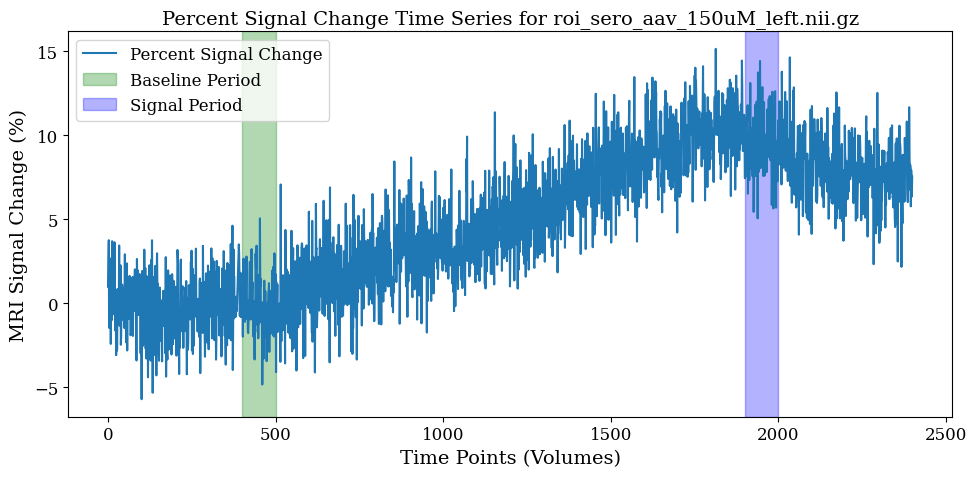

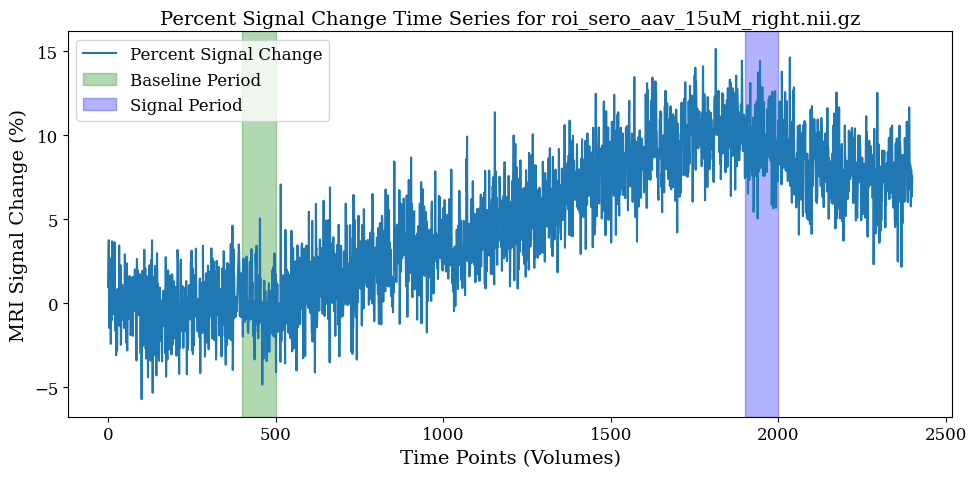

In [ ]:
#Marking ROIs and saving time courses

print_header("Marking ROIs and saving time courses", bcolors.HEADER)

print_statement("Please create ROIs on the functional time series and save them in the following particular format:", bcolors.NOTIFICATION) 
print_statement("roi_{what protein/aav is there}_{is it direct injection or aav}_{analyte injeted}_{hemisphere side}.nii.gz", bcolors.NOTIFICATION)
print_statement("For Example: if GCaMP6f is directly injected in the left hemisphere and dopamine is injected in the right hemisphere following a viral injection, then the following ROIs should be created:", bcolors.NOTIFICATION) 
print_statement("roi_GCaMP6f_direct_left.nii.gz or roi_dopamine_aav_right.nii.gz", bcolors.FAIL)  

subprocess.run(["fsleyes", "mean_fMRI_coregistered_to_struct.nii.gz"])

files_list_roi = os.listdir(cwd)

for file in files_list_roi:
    if file.startswith("roi_") and file.endswith("left.nii.gz"):
        roi_left = file
    if file.startswith("roi_") and file.endswith("right.nii.gz"):
        roi_right = file

mean_signal_left = roi_analysis(roi_left, n_vols, tr, base_start, base_end, sig_start, sig_end)
mean_signal_right = roi_analysis(roi_right, n_vols, tr, base_start, base_end, sig_start, sig_end)


# for files in roi_for_psc:
#     # skip if the file isn't a text file
#       roi_file = files
#       print_statement(f"Extracting time course for ROI: {roi_file}", bcolors.NOTIFICATION)
#       output_file = f"time_course_{roi_file.replace('.nii.gz', '.txt')}"
#       time_course_extraction(roi_file, "fMRI_coregistered_to_struct.nii.gz", output_file)
#       print_statement(f"[OK] Time course saved → {output_file}", bcolors.OKGREEN)

#       #Creating Percent Signal Change graphs for each RO
#       id_arr = list(range(0, n_vols, tr))
#       time_series = np.loadtxt(output_file)
#       # baseline = np.mean(time_series[base_start:base_end])
#       baseline = np.mean(time_series[base_start:base_end])
#       psc = ((time_series - baseline) / baseline) * 100
        # mean_signal = np.mean(psc[sig_start:sig_end])
#       print_statement(f"[OK] Percent Signal Change calculated for ROI: {roi_file}", bcolors.OKGREEN)
#       print("Time Series is:", psc)
#       np.savetxt(f"PSC_time_series_{roi_file.replace('.nii.gz', '.txt')}", psc)
#       plt.figure(figsize=(10, 5))
#       plt.plot(id_arr, psc, label='Percent Signal Change')
#       plt.axvspan(base_start, base_end, color='green', alpha=0.3, label='Baseline Period')
#       plt.axvspan(sig_start, sig_end, color='blue', alpha=0.3, label='Signal Period')
#       plt.title(f'Percent Signal Change Time Series for {roi_file}')
#       plt.xlabel('Time Points (Volumes)')
#       plt.ylabel('MRI Signal Change (%)')
#       plt.legend()
#       plt.tight_layout()
#       graph_file = f"PSC_Time_Series_{roi_file.replace('.nii.gz', '.svg')}"
#       plt.savefig(graph_file, dpi=1200)
#       print_statement(f"[OK] Percent Signal Change graph saved → {graph_file}", bcolors.OKGREEN)   


In [76]:
print (mean_signal_left)
print (mean_signal_right)

9.534655039713883
9.534655039713883


# Voxel-wise Correlation Analysis

In [48]:
#Using the dropdown select the file you want to test the correlation with
fc = FileChooser(cwd)
fc.show_only_dirs = False
display(fc)

FileChooser(path='/Users/njain/Desktop/Naman/AnalysedData/20250428_110140_RGRO_250428_0224_RN_SD_019_0224_1_1/…

In [50]:
#Load the selected file above using nibabel and then select for mask file and seed file
func_file_for_correlation = fc.selected_filename
print(func_file_for_correlation)
img_func = nib.load(func_file_for_correlation)
img_func.shape

matches = matching_nifti_files(cwd, img_func.shape)
dropdown_mask = widgets.Dropdown(options=matches, description='Mask file:', layout=widgets.Layout(width='40%'))
display(dropdown_mask)

dropdown_seed = widgets.Dropdown(options=matches, description='Seed file:', layout=widgets.Layout(width='40%'))
display(dropdown_seed)

mc_func.nii.gz
Reference spatial shape: (64, 16, 64)


Dropdown(description='Mask file:', layout=Layout(width='40%'), options=('cleaned_SCM_func.nii.gz', 'cleaned_mc…

Dropdown(description='Seed file:', layout=Layout(width='40%'), options=('cleaned_SCM_func.nii.gz', 'cleaned_mc…

In [51]:
#Load data and extract voxel wise time series and save it
mask_file_for_correlation = os.path.join(cwd, dropdown_mask.value)
seed_file_for_correlation = os.path.join(cwd, dropdown_seed.value)


var_func = nib.load(func_file_for_correlation).get_fdata()
var_seed = nib.load(seed_file_for_correlation).get_fdata().astype(bool)
var_mask = nib.load(mask_file_for_correlation).get_fdata().astype(bool)

ts_seed = var_func[var_seed, :].T   # (time, voxels)
print("Seed TS:", ts_seed.shape)

ts_mask = var_func[var_mask, :].T   # (time, voxels)
print("Mask TS:", ts_mask.shape)

np.savetxt("roi_voxel_seed_timeseries.txt", ts_seed, fmt="%.6f", delimiter="\t")
np.savetxt("roi_voxel_mask_timeseries.txt", ts_mask, fmt="%.6f", delimiter="\t")

Seed TS: (2400, 9)
Mask TS: (2400, 12726)


## Parameters for selecting start and end index for correlation analysis

In [71]:
# ============================================================
# PARAMETERS
# ============================================================
start_idx_correlation = widgets.IntText(value=10, description="Start Index for Correlation: ")
stop_idx_correlation = widgets.IntText(value=10, description="End Index for Correlation: ")
display(start_idx_correlation, stop_idx_correlation)


IntText(value=10, description='Start Index for Correlation: ')

IntText(value=10, description='End Index for Correlation: ')

Rows written: 12726
Mask voxels: 12726


/var/folders/9x/rqmctbqx6_s9gbnm_25x4skc0006g7/T/ipykernel_13740/917689807.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


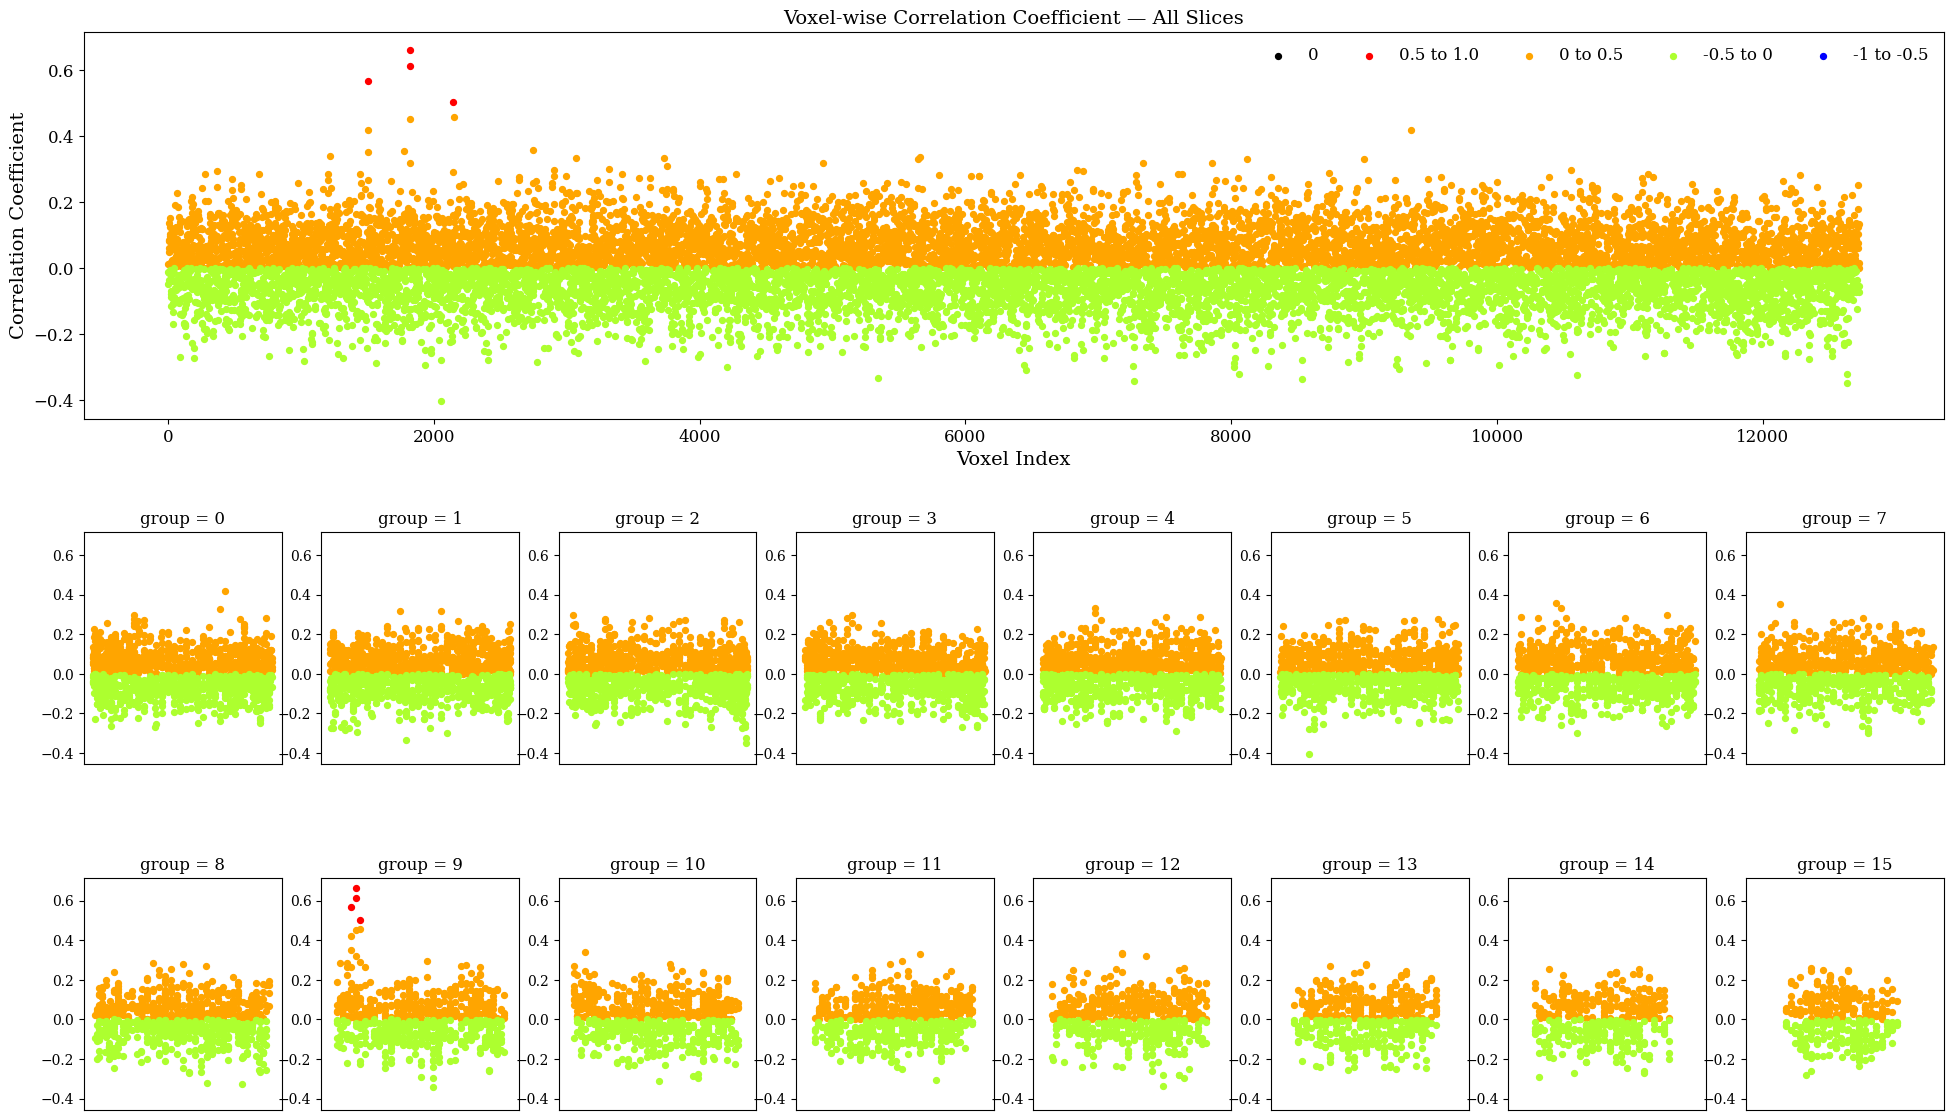

In [72]:
start = start_idx_correlation.value
stop = stop_idx_correlation.value
# ============================================================
# Save voxel indices
# ============================================================
voxel_indices_seed = np.column_stack(np.where(var_seed))
voxel_indices_mask = np.column_stack(np.where(var_mask))

np.savetxt("roi_voxel_indices_seed.txt", voxel_indices_seed, fmt="%d")
np.savetxt("roi_voxel_indices_mask.txt", voxel_indices_mask, fmt="%d")

# ============================================================
# Mean seed time series
# ============================================================
mean_ts_seed = ts_seed.mean(axis=1)
np.savetxt("roi_mean_seed_timeseries.txt", mean_ts_seed, fmt="%.6f")

# Debug slice
np.savetxt("test.txt", mean_ts_seed[start:stop])

# ============================================================
# Correlation computation (TIME DOMAIN)
# ============================================================
correlation_values = np.zeros((2, ts_mask.shape[1]), dtype=np.float32)

x_ts = mean_ts_seed[start:stop]   # TIME series (length = stop-start)

for col in range(ts_mask.shape[1]):
    y_ts = ts_mask[start:stop, col]
    r, p = scipy.stats.pearsonr(x_ts, y_ts)
    correlation_values[0, col] = r
    correlation_values[1, col] = p

# ============================================================
# FDR inputs
# ============================================================
rvals = correlation_values[0]
pvals = correlation_values[1]

# ============================================================
# Fisher z-transform
# ============================================================
eps = np.finfo(np.float32).eps
rvals_clipped = np.clip(rvals, -1 + eps, 1 - eps)
zvals = np.arctanh(rvals_clipped)

# ============================================================
# Save EVERYTHING in one file
# ============================================================
out = np.column_stack((voxel_indices_mask, rvals, pvals, zvals))

np.savetxt(
    "seed_voxelwise_correlation.txt",
    out,
    fmt="%d\t%d\t%d\t%.6f\t%.6e\t%.6f",
    header="x\ty\tz\tr\tp\tz_fisher"
)

print("Rows written:", out.shape[0])
print("Mask voxels:", np.sum(var_mask))

# ============================================================
# -------------------- PLOTTING -------------------------------
# ============================================================
data = np.loadtxt("seed_voxelwise_correlation.txt")
# ---------------------------
# Matplotlib style
# ---------------------------
plt.rcParams['font.family'] = ['serif']
plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

# ---------------------------
# Data (VOXEL DOMAIN)
# ---------------------------
group_ids = data[:, 1].astype(int)   # voxel groups
y_all     = data[:, 3]               # correlation coefficients

assert y_all.shape[0] == group_ids.shape[0], "Voxel data mismatch"

x_vox = np.arange(y_all.shape[0])    # voxel index axis
unique_groups = np.unique(group_ids)

# ---------------------------
# Figure + GridSpec
# ---------------------------
fig = plt.figure(figsize=(24, 14))
gs = GridSpec(
    nrows=3,
    ncols=8,
    height_ratios=[2.5, 1.5, 1.5],
    hspace=0.4
)

# ============================================================
# Helper function: scatter by correlation range
# ============================================================
def scatter_by_range(ax, x, y):
    mask_zero        = (y == 0)
    mask_red         = (y > 0.5)  & (y <= 1.0)
    mask_orange      = (y > 0.0)  & (y <= 0.5)
    mask_greenyellow = (y >= -0.5) & (y < 0.0)
    mask_blue        = (y >= -1.0) & (y < -0.5)

    ax.scatter(x[mask_zero],        y[mask_zero],        color="black",       s=18, label="0")
    ax.scatter(x[mask_red],         y[mask_red],         color="red",         s=18, label="0.5 to 1.0")
    ax.scatter(x[mask_orange],      y[mask_orange],      color="orange",      s=18, label="0 to 0.5")
    ax.scatter(x[mask_greenyellow], y[mask_greenyellow], color="greenyellow", s=18, label="-0.5 to 0")
    ax.scatter(x[mask_blue],        y[mask_blue],        color="blue",        s=18, label="-1 to -0.5")

# ============================================================
# TOP: Combined plot (ALL voxels)
# ============================================================
ax_top = fig.add_subplot(gs[0, :])

scatter_by_range(ax_top, x_vox, y_all)

ax_top.set_title("Voxel-wise Correlation Coefficient — All Slices")
ax_top.set_ylabel("Correlation Coefficient")
ax_top.set_xlabel("Voxel Index")

handles, labels = ax_top.get_legend_handles_labels()
ax_top.legend(handles, labels, ncol=5, frameon=False, loc="upper right")

# ============================================================
# BOTTOM: Grouped subplots (8 × 2)
# ============================================================
for idx, g in enumerate(unique_groups[:16]):  # max 16 subplots
    row = 1 + idx // 8
    col = idx % 8

    ax = fig.add_subplot(gs[row, col], sharex=ax_top, sharey=ax_top)

    group_mask = (group_ids == g)
    x_g = x_vox[group_mask]
    y_g = y_all[group_mask]

    scatter_by_range(ax, x_g, y_g)

    ax.set_title(f"group = {g}", fontsize=12)

    ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis="y", labelsize=10)

# ---------------------------
# Save figure
# ---------------------------
fig.tight_layout()
fig.savefig("corr_coeff_combined_and_grouped.svg", dpi=1200)
# plt.close(fig)


# Entering all data analysis record in the SQL Database

In [ ]:

#Connect to a new SQlite database
conn = sqlite3.connect("analysis_record_test.db")
cursor = conn.cursor()

#drop old table if it exists
# cursor.execute("DROP TABLE IF EXISTS Data_Analysis")
conn.commit()


analysis_done_by = getpass.getuser()

# This is validation step, if any value is missing that indicates that the previous steps have not been successfully implemented. 

required_fields = {
    "analysis_done_by": analysis_done_by,
    "root_location": root_location,
    "subject_id": subject_id,
    "analysis_folder_name": folder_created,
    "functional_run": func_scan_number,
    "structural_run": struct_scan_number,
    "temporal_res": tr,
    "window_duration": win_entered.value,
    "spatial_smoothing": fwhm_kernel,
    "spatial_smoothing_coreg_image": fwhm_kernel_coregsitered,
    "roi_left": roi_left,
    "mean_signal_change_left": mean_signal_left,
    "roi_right": roi_right,
    "mean_signal_change_right": mean_signal_right,
    "start_idx_correlation": start_idx_correlation.value,
    "end_idx_correlation": stop_idx_correlation.value,
}


def validate_analysis_inputs(fields):
    missing = [
        name for name, value in fields.items()
        if value is None or (isinstance(value, str) and value.strip() == "")
    ]

    if missing:
        raise RuntimeError(
            "Analysis NOT COMPLETE, Please run your complete pipeline for successful record.\n"
            f"Missing fields: {', '.join(missing)}"
        )

    if tr <= 0:
        raise RuntimeError("Invalid temporal resolution (TR must be > 0)")

    if win_entered.value <= 0:
        raise RuntimeError("Invalid window duration")

    if start_idx_correlation.value >= stop_idx_correlation.value:
        raise RuntimeError("Invalid correlation window indices")


# Run validation
validate_analysis_inputs(required_fields)

# Here we establish connection to the database

db_path = "analysis_record_test.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Here we are creating the table

cursor.execute("""
CREATE TABLE IF NOT EXISTS Data_Analysis (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    analysis_done_by TEXT,
    root_location TEXT,
    subject_id TEXT,
    analysis_folder_name TEXT,
    functional_run INTEGER,
    structural_run INTEGER,
    temporal_res REAL,
    window_duration INTEGER,
    spatial_smoothing REAL,
    spatial_smoothing_coreg_image REAL,
    roi_left TEXT,
    mean_signal_change_left FLOAT,
    roi_right TEXT,
    mean_signal_change_right FLOAT,
    start_idx_correlation INTEGER,
    end_idx_correlation INTEGER,
    created_at TEXT DEFAULT CURRENT_TIMESTAMP
)
""")

conn.commit()

# Based on the parameters used to analyse data throughout, enter them in the SQL database to create a record of what parameters were used for which data

Data_Analysis = tuple(required_fields.values())

cursor.execute("""
INSERT INTO Data_Analysis (
    analysis_done_by,
    root_location,
    subject_id,
    analysis_folder_name,
    functional_run,
    structural_run,
    temporal_res,
    window_duration,
    spatial_smoothing,
    spatial_smoothing_coreg_image,
    roi_left,
    mean_signal_change_left,
    roi_right,
    mean_signal_change_right,
    start_idx_correlation,
    end_idx_correlation
)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
""", Data_Analysis)

conn.commit()

# Here we get the print of the data that we entered

df = pd.read_sql("SELECT * FROM Data_Analysis ORDER BY id DESC", conn)
print(df.head())

conn.close()


   id analysis_done_by         root_location                  subject_id  \
0   1            njain  /Users/njain/Desktop  RGRO_250428_0224_RN_SD_019   

      analysis_folder_name  functional_run  structural_run  temporal_res  \
0  2026_01_04_232817_njain              19              20           1.0   

   window_duration  spatial_smoothing  spatial_smoothing_coreg_image  \
0              100                0.7                           0.12   

                         roi_left  mean_signal_change_left  \
0  roi_sero_aav_150uM_left.nii.gz                 9.534655   

                        roi_right  mean_signal_change_right  \
0  roi_sero_aav_15uM_right.nii.gz                  9.534655   

   start_idx_correlation  end_idx_correlation           created_at  
0                   1900                 2000  2026-01-04 23:58:00  
